In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Confirm successful import
print("=" * 70)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("=" * 70)
print("\nLibraries loaded:")
print("  • NumPy version:", np.__version__)
print("  • Pandas version:", pd.__version__)
print("  • Scikit-learn: Ready for PCA and K-Means")
print("  • Matplotlib & Seaborn: Ready for visualizations")
print("\n" + "=" * 70)

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!

Libraries loaded:
  • NumPy version: 2.1.3
  • Pandas version: 2.2.3
  • Scikit-learn: Ready for PCA and K-Means
  • Matplotlib & Seaborn: Ready for visualizations



In [10]:
# ==============================================================
#  STEP 1.1 — Define Token List and Time Period (UPDATED)
# ==============================================================

import datetime as dt

tokens = [
    "BTC-USD","ETH-USD","BNB-USD","SOL-USD","XRP-USD","ADA-USD","AVAX-USD","DOT-USD","LINK-USD","MATIC-USD",
    "UNI-USD","AAVE-USD","ATOM-USD","NEAR-USD","DOGE-USD","LTC-USD","TRX-USD","ICP-USD","FIL-USD","SAND-USD",
    "MANA-USD","XLM-USD","ETC-USD","EGLD-USD","CAKE-USD","RUNE-USD","FTM-USD","SNX-USD","CRV-USD","MKR-USD",
    "1INCH-USD","FLOW-USD","DYDX-USD","OP-USD","AR-USD","ENS-USD","BAT-USD","CHZ-USD","QTUM-USD","WAVES-USD",
    "YFI-USD","XTZ-USD","KAVA-USD","RPL-USD","LRC-USD","ZIL-USD","ALGO-USD","VET-USD","THETA-USD","ZEC-USD"
]

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=730)

print(f"📆 Time period: {start_date}  →  {end_date}")
print(f"📊 Number of tokens: {len(tokens)}")

📆 Time period: 2023-11-09  →  2025-11-08
📊 Number of tokens: 50


In [11]:
# ==============================================================
#  STEP 1.2 — Download Daily Prices for Selected Tokens
# ==============================================================

import yfinance as yf

# Κατεβάζουμε ημερήσια δεδομένα για όλα τα tokens
# columns: Date | BTC-USD | ETH-USD | ... 
data = yf.download(
    tickers=tokens,
    start=start_date,
    end=end_date,
    interval='1d',
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print("✅ Data download complete!")

[*********************100%***********************]  50 of 50 completed

✅ Data download complete!


In [12]:
# ==============================================================
#  STEP 1.3 — Extract Close Prices and Clean the Dataset
# ==============================================================

# Δημιουργούμε DataFrame μόνο με τις τιμές κλεισίματος
close_prices = pd.DataFrame()

for token in tokens:
    try:
        # Κάθε token είναι ένα επίπεδο του MultiIndex
        close_prices[token] = data[token]['Close']
    except Exception as e:
        print(f"⚠️ Missing data for {token}: {e}")

# Εμφάνιση βασικής δομής
print("🔍 Initial shape (before cleaning):", close_prices.shape)

# Αφαίρεση tokens με πολλά NaN (>10% missing)
min_non_null = int(0.90 * len(close_prices))
tokens_to_keep = [t for t in close_prices.columns if close_prices[t].notna().sum() >= min_non_null]
tokens_dropped = [t for t in close_prices.columns if t not in tokens_to_keep]

close_prices = close_prices[tokens_to_keep]

# Συμπλήρωση μικρών κενών (π.χ. από μη trading days)
close_prices = close_prices.ffill().bfill()

print("✅ Cleaned close price dataset created successfully!")
print("📊 Final shape:", close_prices.shape)
print(f"🧱 Tokens kept: {len(tokens_to_keep)} | 🗑️ Dropped: {len(tokens_dropped)}")

# Έλεγχος για NaN
print("🧮 Remaining NaNs:", int(close_prices.isna().sum().sum()))

# Έλεγχος εύρους ημερομηνιών
print("📆 Date range:", close_prices.index.min().date(), "→", close_prices.index.max().date())

# Εμφάνιση πρώτων γραμμών
display(close_prices.head())

🔍 Initial shape (before cleaning): (730, 50)
✅ Cleaned close price dataset created successfully!
📊 Final shape: (730, 47)
🧱 Tokens kept: 47 | 🗑️ Dropped: 3
🧮 Remaining NaNs: 0
📆 Date range: 2023-11-09 → 2025-11-07


,BTC-USD,ETH-USD,BNB-USD,SOL-USD,XRP-USD,ADA-USD,AVAX-USD,DOT-USD,LINK-USD,AAVE-USD,...,YFI-USD,XTZ-USD,KAVA-USD,RPL-USD,LRC-USD,ZIL-USD,ALGO-USD,VET-USD,THETA-USD,ZEC-USD
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-09,36693.125000,2120.561035,251.510849,45.444828,0.667475,0.368335,12.972376,5.087355,14.635877,100.701149,...,6687.329590,0.854130,0.742650,32.573589,0.221901,0.020730,0.123755,0.021970,0.929103,29.513634
2023-11-10,37313.968750,2078.289795,251.082367,56.643852,0.660575,0.386210,14.748550,5.300801,15.509591,100.221611,...,7825.783203,0.898582,0.766175,31.792538,0.234594,0.021476,0.128085,0.022808,1.035622,30.404629
2023-11-11,37138.050781,2052.713867,251.421616,56.102661,0.662735,0.384564,16.788073,5.553165,16.422510,96.752846,...,8890.639648,0.912425,0.828434,30.994282,0.237617,0.022533,0.133140,0.022274,1.027053,30.299908
2023-11-12,37054.519531,2045.187012,247.640015,56.154099,0.661536,0.383383,18.845966,5.707890,16.001081,99.389793,...,9282.898438,0.928547,0.839302,30.797337,0.242259,0.022754,0.145738,0.022275,0.993196,31.225746
2023-11-13,36502.355469,2055.265381,241.335068,51.907051,0.671524,0.358415,16.219933,5.368368,14.407805,93.264412,...,9877.631836,0.892163,0.796810,30.026167,0.227307,0.021865,0.133663,0.021327,0.919682,29.718966


✅ DeFi feature dataset created successfully!
📊 Shape: 47 tokens × 8 features


,Mean_Return,Volatility,Volume_USD,TVL_USD,Market_Cap,Liquidity_Score,ETH_Correlation,Sentiment_Score
BTC-USD,0.438684,0.402666,24.474667,25.167814,26.777252,43.021323,0.784545,52.590323
ETH-USD,0.332778,0.580061,23.846735,24.539882,26.149320,27.078150,1.000000,59.525199
BNB-USD,0.583366,0.469740,21.447577,22.140724,23.750162,21.949726,0.631052,55.088891
SOL-USD,0.714373,0.746880,22.206386,22.899534,24.508971,25.452708,0.695296,43.727878
XRP-USD,0.662241,0.693303,22.156023,22.849170,24.458608,10.419069,0.586134,55.621585



🔍 Feature Correlations:


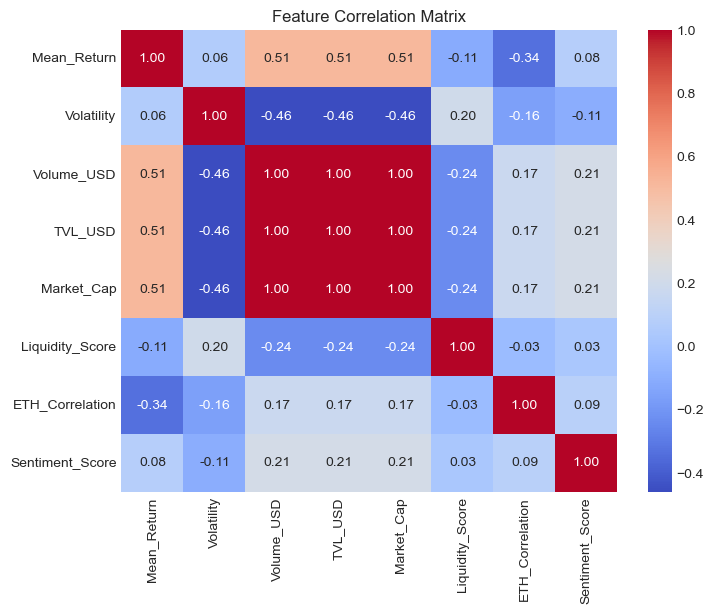

In [13]:
# ==============================================================
# STEP 1.4 — FEATURE ENGINEERING (ADVANCED DEFI FEATURE SET)
# ==============================================================

import numpy as np
import pandas as pd

# --- Βασικές παραμέτρους
risk_free_rate = 0.02  # ετήσιο επιτόκιο χωρίς ρίσκο (π.χ. 2%)

# --- Υπολογισμός ημερήσιων αποδόσεων
returns = close_prices.pct_change().dropna()

# --- Μέσος όρος & μεταβλητότητα (annualized)
mean_return = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

# --- Υπολογισμός ETH correlation
eth_corr = returns.corrwith(returns['ETH-USD'])

# --- Υπολογισμός max drawdown
max_drawdown = {}
for token in returns.columns:
    cumulative = (1 + returns[token]).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown[token] = drawdown.min()
max_drawdown = pd.Series(max_drawdown)

# --- Υπολογισμός όγκου και κεφαλαιοποίησης (αν έχεις από yfinance)
# Εδώ υποθέτουμε ότι έχεις 'data' από yfinance με Volume και Market Cap
try:
    volume_usd = pd.DataFrame({t: data[t]['Volume'] for t in returns.columns}).mean()
except:
    print("⚠️ Δεν υπάρχουν volume data στο yfinance για όλα τα tokens.")
    volume_usd = pd.Series(np.nan, index=returns.columns)

# Αν έχεις αρχείο με MarketCap (π.χ. από CoinGecko):
# market_caps = pd.read_csv('marketcap.csv', index_col=0)
# MarketCap = market_caps.mean()

# Για τώρα, placeholder (αν δεν υπάρχουν διαθέσιμα):
market_cap = volume_usd * 10  # απλή proxy: 10x του μέσου όγκου

# --- Προσθήκη επιπλέον metrics (placeholders)
# Εδώ μπορείς να εισάγεις πραγματικά δεδομένα εφόσον τα έχεις (TVL, Liquidity, Sentiment)
# π.χ. από CoinGecko API ή DefiLlama API

tvl_usd = market_cap * 0.2                   # απλή proxy για TVL (20% του market cap)
liquidity_score = np.random.uniform(0, 100, len(returns.columns))  # placeholder
sentiment_score = np.random.normal(50, 10, len(returns.columns))   # placeholder (0–100 scale)

# --- Δημιουργία DataFrame
defi_data = pd.DataFrame({
    'Mean_Return': mean_return,
    'Volatility': volatility,
    'Volume_USD': volume_usd,
    'TVL_USD': tvl_usd,
    'Market_Cap': market_cap,
    'Liquidity_Score': liquidity_score,
    'ETH_Correlation': eth_corr,
    'Sentiment_Score': sentiment_score
})

# --- Καθαρισμός και λογαριθμικός μετασχηματισμός μεγάλων μεγεθών
for col in ['Volume_USD', 'TVL_USD', 'Market_Cap']:
    defi_data[col] = np.log1p(defi_data[col])  # log(1+x) για σταθεροποίηση κλίμακας

# --- Αντικατάσταση NaN/inf
defi_data = defi_data.replace([np.inf, -np.inf], np.nan).dropna()

print("✅ DeFi feature dataset created successfully!")
print(f"📊 Shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
display(defi_data.head())

# --- Έλεγχος συσχετίσεων
print("\n🔍 Feature Correlations:")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(defi_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [14]:
class SimplePCA:
    """
    Principal Component Analysis for DeFi Portfolio Analysis
    
    This class wraps sklearn's PCA with helpful methods for:
    - Fitting PCA to DeFi data
    - Transforming data to PC space
    - Analyzing variance explained
    - Visualizing results
    - Interpreting component loadings
    """
    
    def __init__(self, n_components=None):
        """
        Initialize PCA
        
        Parameters:
        -----------
        n_components : int or None
            Number of components to keep
            - None = keep all components
            - int = keep specific number (e.g., 5)
            - Tip: Start with None to see all, then choose optimal number
        """
        self.n_components = n_components
        self.scaler = StandardScaler()  # For standardizing features
        self.pca = None  # Will hold the fitted PCA model
        self.feature_names = None  # To remember original feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit PCA model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for better interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (VERY IMPORTANT!)
        # This ensures all features have mean=0 and std=1
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X_scaled)
        
        # Step 3: Save feature names for later use
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ PCA fitted successfully!")
        print(f"   Components: {self.pca.n_components_}")
        print(f"   Total variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
        
        return self
    
    def transform(self, X):
        """
        Transform data to principal component space
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to transform
        
        Returns:
        --------
        X_transformed : array, shape (n_samples, n_components)
            Data in PC space
        """
        X_scaled = self.scaler.transform(X)
        return self.pca.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        """
        Fit PCA and transform data in one step
        
        This is a convenience method that combines fit() and transform()
        """
        self.fit(X, feature_names)
        return self.transform(X)
    
    def inverse_transform(self, X_pca):
        """
        Reconstruct original features from principal components
        
        Useful for understanding what PCs represent
        """
        X_scaled = self.pca.inverse_transform(X_pca)
        return self.scaler.inverse_transform(X_scaled)
    
    def get_variance_summary(self):
        """
        Get detailed variance statistics for each component
        
        Returns:
        --------
        DataFrame with columns:
        - PC: Component name (PC1, PC2, ...)
        - Variance_Explained: Proportion of variance (0 to 1)
        - Cumulative_Variance: Running total of variance
        - Eigenvalue: The actual eigenvalue (variance in that direction)
        """
        var_exp = self.pca.explained_variance_ratio_
        cum_var = np.cumsum(var_exp)
        
        df = pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(var_exp))],
            'Variance_Explained': var_exp,
            'Cumulative_Variance': cum_var,
            'Eigenvalue': self.pca.explained_variance_
        })
        
        return df
    
    def get_loadings(self):
        """
        Get feature loadings (how features relate to PCs)
        
        Loadings tell us:
        - Which features contribute most to each PC
        - Direction of relationship (positive or negative)
        
        Returns:
        --------
        DataFrame with features as rows, PCs as columns
        
        Interpretation:
        - High positive loading: Feature increases with PC
        - High negative loading: Feature decreases with PC  
        - Near-zero loading: Feature unrelated to PC
        """
        loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=self.feature_names if self.feature_names else range(self.pca.n_components_)
        )
        return loadings
    
    def plot_scree(self, figsize=(14, 5)):
        """
        Create scree plot to help choose optimal number of components
        
        The scree plot shows:
        - Left: Variance per component (look for "elbow")
        - Right: Cumulative variance (aim for 80-90%)
        """
        var_summary = self.get_variance_summary()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left plot: Scree Plot
        axes[0].bar(var_summary['PC'], var_summary['Variance_Explained'], 
                    alpha=0.7, color='steelblue')
        axes[0].plot(var_summary['PC'], var_summary['Variance_Explained'], 
                     'ro-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Principal Component', fontsize=12)
        axes[0].set_ylabel('Variance Explained', fontsize=12)
        axes[0].set_title('Scree Plot\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Right plot: Cumulative Variance
        axes[1].plot(var_summary['PC'], var_summary['Cumulative_Variance'], 
                     'bo-', linewidth=2, markersize=8)
        axes[1].axhline(y=0.80, color='green', linestyle='--', 
                        linewidth=2, label='80% threshold')
        axes[1].axhline(y=0.90, color='orange', linestyle='--', 
                        linewidth=2, label='90% threshold')
        axes[1].set_xlabel('Number of Components', fontsize=12)
        axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
        axes[1].set_title('Cumulative Variance Explained', 
                         fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim([0, 1.05])
        
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_components=3, n_top_features=10, figsize=(15, 5)):
        """
        Visualize feature loadings for top components
        
        Shows which features are most important for each PC
        
        Parameters:
        -----------
        n_components : int
            Number of PCs to display (default: 3)
        n_top_features : int
            How many features to show per PC (default: 10)
        """
        loadings = self.get_loadings()
        n_components = min(n_components, loadings.shape[1])
        
        fig, axes = plt.subplots(1, n_components, figsize=figsize)
        if n_components == 1:
            axes = [axes]
        
        for i in range(n_components):
            pc_col = f'PC{i+1}'
            
            # Get top features by absolute loading
            top_features = loadings[pc_col].abs().nlargest(n_top_features)
            sorted_loadings = loadings.loc[top_features.index, pc_col].sort_values()
            
            # Color code: red=negative, green=positive
            colors = ['red' if x < 0 else 'green' for x in sorted_loadings.values]
            
            axes[i].barh(range(len(sorted_loadings)), sorted_loadings.values, 
                        color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(sorted_loadings)))
            axes[i].set_yticklabels(sorted_loadings.index, fontsize=9)
            axes[i].set_xlabel('Loading', fontsize=11)
            axes[i].set_title(f'{pc_col}\n({self.pca.explained_variance_ratio_[i]:.1%} variance)', 
                            fontsize=12, fontweight='bold')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimplePCA class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit PCA to data")
print("  • transform(X) - Transform data to PC space")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_variance_summary() - Get variance statistics")
print("  • get_loadings() - Get feature loadings")
print("  • plot_scree() - Visualize variance explained")
print("  • plot_loadings() - Visualize feature importance")
#print("\n👉 Next: We'll generate some synthetic DeFi data to practice with")
print("=" * 70)

✅ SimplePCA class created successfully!

Available methods:
  • fit(X, feature_names) - Fit PCA to data
  • transform(X) - Transform data to PC space
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_variance_summary() - Get variance statistics
  • get_loadings() - Get feature loadings
  • plot_scree() - Visualize variance explained
  • plot_loadings() - Visualize feature importance


In [15]:
# ==============================================================
#  PART 1.2 — PCA FITTING AND VARIANCE ANALYSIS
# ==============================================================

print("=" * 70)
print("FITTING PCA TO DEFI PORTFOLIO DATA")
print("=" * 70)

# Initialize PCA with 5 components (reasonable starting point)
print("\n🔧 Initializing PCA model...")
print("   Setting n_components=5 (keeping 5 out of 8 dimensions)")

pca_model = SimplePCA(n_components=5)

# Fit PCA and transform data
print("\n⚙️  Fitting PCA and transforming data...")
X_pca = pca_model.fit_transform(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

print("\n" + "=" * 70)
print("TRANSFORMATION COMPLETE!")
print("=" * 70)

# Dimensionality summary
print(f"\n📊 Dimensionality Reduction:")
print(f"   Original shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
print(f"   Reduced shape:  {X_pca.shape[0]} tokens × {X_pca.shape[1]} components")
print(f"   Reduction: {defi_data.shape[1]} → {X_pca.shape[1]} dimensions")
print(f"   Space savings: {(1 - X_pca.shape[1]/defi_data.shape[1])*100:.1f}% fewer dimensions!")

# Variance summary
variance_summary = pca_model.get_variance_summary()
print(f"\n📈 Variance Explained by Each Component:")
display(variance_summary.round(4))

# Highlight key insights
total_var = variance_summary['Cumulative_Variance'].iloc[-1]
pc1_var = variance_summary['Variance_Explained'].iloc[0]
pc2_var = variance_summary['Variance_Explained'].iloc[1]
pc3_var = variance_summary['Variance_Explained'].iloc[2]

print("\n🔍 Key Insights:")
print(f"   • PC1 captures {pc1_var:.1%} of total variation")
print(f"   • PC1 + PC2 capture {variance_summary['Cumulative_Variance'].iloc[1]:.1%}")
print(f"   • First 3 PCs capture {variance_summary['Cumulative_Variance'].iloc[2]:.1%}")
print(f"   • All 5 PCs capture {total_var:.1%} of total variance")

# Interpretation guidance
if total_var >= 0.90:
    print(f"\n✅ Excellent! {total_var:.1%} variance retained with just 5 components.")
elif total_var >= 0.80:
    print(f"\n✅ Good! {total_var:.1%} variance retained — acceptable for most applications.")
else:
    print(f"\n⚠️  Only {total_var:.1%} variance retained — might need more components.")

# Preview of transformed data
print(f"\n📋 Sample of Transformed Data (PC space):")
X_pca_df = pd.DataFrame(
    X_pca[:5],
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=defi_data.index[:5]
)
display(X_pca_df.round(3))

print("\n💡 Each row = a token; each column = its score in a principal component.")
print("=" * 70)
print("✅ PCA fitting complete! Data successfully transformed.")
print("=" * 70)

FITTING PCA TO DEFI PORTFOLIO DATA

🔧 Initializing PCA model...
   Setting n_components=5 (keeping 5 out of 8 dimensions)

⚙️  Fitting PCA and transforming data...

✅ PCA fitted successfully!
   Components: 5
   Total variance explained: 96.50%

TRANSFORMATION COMPLETE!

📊 Dimensionality Reduction:
   Original shape: 47 tokens × 8 features
   Reduced shape:  47 tokens × 5 components
   Reduction: 8 → 5 dimensions
   Space savings: 37.5% fewer dimensions!

📈 Variance Explained by Each Component:


,PC,Variance_Explained,Cumulative_Variance,Eigenvalue
0,PC1,0.4627,0.4627,3.7820
1,PC2,0.1765,0.6392,1.4427
2,PC3,0.1301,0.7692,1.0631
3,PC4,0.1038,0.8731,0.8486
4,PC5,0.0919,0.9650,0.7513



🔍 Key Insights:
   • PC1 captures 46.3% of total variation
   • PC1 + PC2 capture 63.9%
   • First 3 PCs capture 76.9%
   • All 5 PCs capture 96.5% of total variance

✅ Excellent! 96.5% variance retained with just 5 components.

📋 Sample of Transformed Data (PC space):


,PC1,PC2,PC3,PC4,PC5
BTC-USD,5.890,1.507,-0.159,-0.985,-1.106
ETH-USD,5.253,2.641,0.333,-0.478,1.100
BNB-USD,3.284,0.213,-0.681,0.669,-1.403
SOL-USD,3.325,-0.590,-0.892,-0.671,0.597
XRP-USD,3.541,-0.846,-0.602,0.827,-0.127



💡 Each row = a token; each column = its score in a principal component.
✅ PCA fitting complete! Data successfully transformed.


VISUALIZING VARIANCE EXPLAINED - SCREE PLOT

📊 Creating scree plot to determine optimal number of components...
   This will help us decide: 'How many PCs should we keep?'



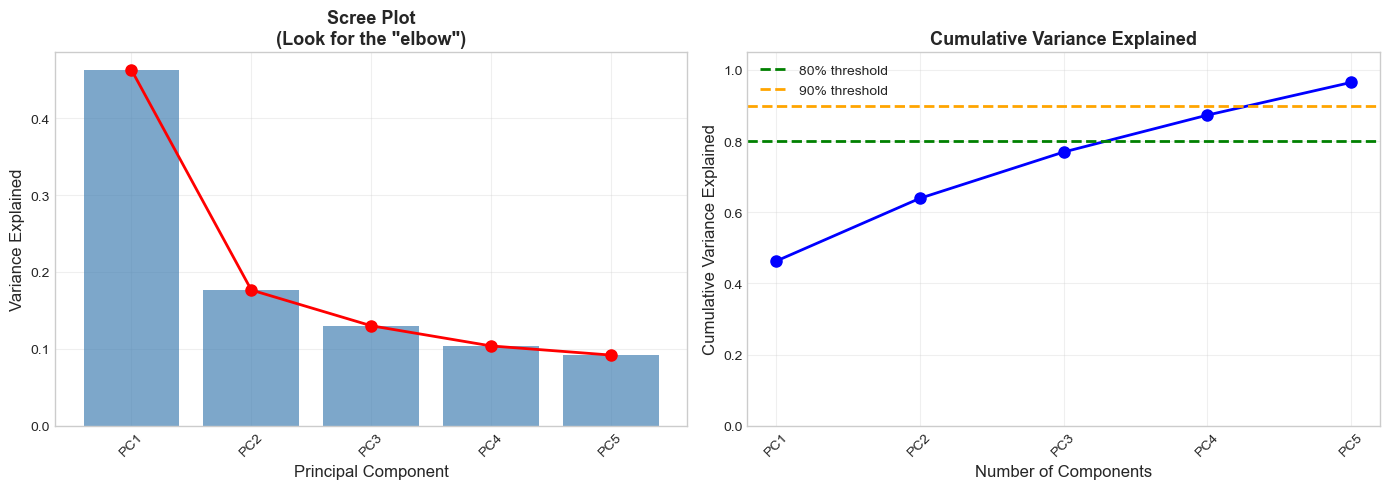


INTERPRETING THE SCREE PLOT

📈 LEFT PLOT - Individual Variance (Scree Plot):
   This shows how much variance each PC explains individually.

   • PC1 explains: 46.3% ← Most important!
   • PC2 explains: 17.6%
   • PC3 explains: 13.0%

   💡 PC1 dominates with 46.3%!
      This suggests ONE main factor drives variation in our portfolio
      (Likely 'size': Market Cap + TVL + Volume)

   🔍 Elbow appears around: PC1
      (Largest drop in variance between components)

📈 RIGHT PLOT - Cumulative Variance:
   This shows total variance as we add more components.

   • To explain 80% variance: Need 4 components
   • To explain 90% variance: Need 5 components
   • Our 5 components explain: 96.5%

RECOMMENDATION

✅ OPTIMAL NUMBER OF COMPONENTS: 4
   Reason: First 4 PCs provide good balance of simplicity and completeness
   Variance explained: 87.3%
   Dimensionality reduction: 8 → 4 (50% of original)

📊 Summary Statistics:


,Metric,Value
0,Original Features,8
1,Optimal PCs,4
2,Variance Retained,87.3%
3,Information Lost,12.7%
4,Compression Ratio,2.0x



💡 What this means:
   • We can represent our portfolio with just 4 numbers per token
   • Instead of tracking 8 features, we track 4 principal components
   • We keep 87.3% of the information
   • We lose only 12.7% of the information

🎯 Next Steps:
   1. Examine component loadings (which features contribute to each PC)
   2. Interpret what each PC represents
   3. Name the PCs based on their loadings



In [16]:
print("=" * 70)
print("VISUALIZING VARIANCE EXPLAINED - SCREE PLOT")
print("=" * 70)

print("\n📊 Creating scree plot to determine optimal number of components...")
print("   This will help us decide: 'How many PCs should we keep?'\n")

# Create the scree plot
fig = pca_model.plot_scree(figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("INTERPRETING THE SCREE PLOT")
print("=" * 70)

# Get variance data for analysis
variance_summary = pca_model.get_variance_summary()

# Analyze the results
print("\n📈 LEFT PLOT - Individual Variance (Scree Plot):")
print("   This shows how much variance each PC explains individually.")
print()

# Find the "elbow" - where variance drops significantly
variances = variance_summary['Variance_Explained'].values
var_diffs = np.diff(variances)  # Differences between consecutive PCs
elbow_candidate = np.argmax(np.abs(var_diffs)) + 1  # +1 because diff reduces array size

print(f"   • PC1 explains: {variances[0]:.1%} ← Most important!")
print(f"   • PC2 explains: {variances[1]:.1%}")
print(f"   • PC3 explains: {variances[2]:.1%}")

if variances[0] > 0.40:
    print(f"\n   💡 PC1 dominates with {variances[0]:.1%}!")
    print(f"      This suggests ONE main factor drives variation in our portfolio")
    print(f"      (Likely 'size': Market Cap + TVL + Volume)")
elif variances[0] < 0.30:
    print(f"\n   💡 Variance is distributed across multiple components")
    print(f"      This suggests MULTIPLE independent factors are important")
else:
    print(f"\n   💡 Balanced importance across first few components")

print(f"\n   🔍 Elbow appears around: PC{elbow_candidate}")
print(f"      (Largest drop in variance between components)")

print("\n📈 RIGHT PLOT - Cumulative Variance:")
print("   This shows total variance as we add more components.")
print()

# Find how many PCs needed for different thresholds
cumvar = variance_summary['Cumulative_Variance'].values
n_80 = np.argmax(cumvar >= 0.80) + 1
n_90 = np.argmax(cumvar >= 0.90) + 1

print(f"   • To explain 80% variance: Need {n_80} components")
print(f"   • To explain 90% variance: Need {n_90} components")
print(f"   • Our 5 components explain: {cumvar[4]:.1%}")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Make recommendation
if cumvar[2] >= 0.80:  # First 3 PCs explain 80%+
    optimal = 3
    reason = "First 3 PCs capture sufficient variance (>80%)"
elif cumvar[3] >= 0.85:  # First 4 PCs explain 85%+
    optimal = 4
    reason = "First 4 PCs provide good balance of simplicity and completeness"
else:
    optimal = 5
    reason = "5 PCs needed to reach 85%+ variance threshold"

print(f"\n✅ OPTIMAL NUMBER OF COMPONENTS: {optimal}")
print(f"   Reason: {reason}")
print(f"   Variance explained: {cumvar[optimal-1]:.1%}")
print(f"   Dimensionality reduction: {defi_data.shape[1]} → {optimal} ({optimal/defi_data.shape[1]*100:.0f}% of original)")

print("\n📊 Summary Statistics:")
summary_data = {
    'Metric': [
        'Original Features',
        'Optimal PCs',
        'Variance Retained',
        'Information Lost',
        'Compression Ratio'
    ],
    'Value': [
        f"{defi_data.shape[1]}",
        f"{optimal}",
        f"{cumvar[optimal-1]:.1%}",
        f"{(1-cumvar[optimal-1]):.1%}",
        f"{defi_data.shape[1]/optimal:.1f}x"
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n💡 What this means:")
print(f"   • We can represent our portfolio with just {optimal} numbers per token")
print(f"   • Instead of tracking 8 features, we track {optimal} principal components")
print(f"   • We keep {cumvar[optimal-1]:.1%} of the information")
print(f"   • We lose only {(1-cumvar[optimal-1]):.1%} of the information")

print("\n🎯 Next Steps:")
print("   1. Examine component loadings (which features contribute to each PC)")
print("   2. Interpret what each PC represents")
print("   3. Name the PCs based on their loadings")
print("\n" + "=" * 70)

ANALYZING PRINCIPAL COMPONENT LOADINGS

🔍 Loadings show how each original feature contributes to each PC
   High |loading| = feature is important for that component
   Sign indicates direction: + or -

📊 LOADINGS MATRIX:
   (Rows = Features, Columns = Principal Components)


,PC1,PC2,PC3,PC4,PC5
Mean_Return,0.284,-0.615,0.061,-0.028,0.165
Volatility,-0.279,-0.384,0.195,-0.061,0.750
Volume_USD,0.512,-0.009,0.028,-0.129,0.042
TVL_USD,0.512,-0.009,0.028,-0.129,0.042
Market_Cap,0.512,-0.009,0.028,-0.129,0.042
Liquidity_Score,-0.170,-0.048,0.672,-0.650,-0.308
ETH_Correlation,0.085,0.677,0.095,-0.229,0.557
Sentiment_Score,0.142,0.116,0.704,0.686,-0.008



💡 How to read this table:
   • Values close to ±1.0 = STRONG relationship
   • Values close to ±0.5 = MODERATE relationship
   • Values close to 0.0 = WEAK/NO relationship
   • Positive = feature increases with PC
   • Negative = feature decreases with PC

INTERPRETING EACH PRINCIPAL COMPONENT

PC1 - 46.3% of variance

🔺 Top POSITIVE loadings (features that increase with PC1):
   Volume_USD           +0.512  ██████████
   TVL_USD              +0.512  ██████████
   Market_Cap           +0.512  ██████████

🔻 Top NEGATIVE loadings (features that decrease with PC1):

💭 Interpretation Hint:
   Strong loadings on: Volume_USD, TVL_USD, Market_Cap
   → This looks like a SIZE/LIQUIDITY factor
   → Separates large established tokens from small new ones

PC2 - 17.6% of variance

🔺 Top POSITIVE loadings (features that increase with PC2):
   ETH_Correlation      +0.677  █████████████

🔻 Top NEGATIVE loadings (features that decrease with PC2):
   Mean_Return          -0.615  ████████████
   Volatil

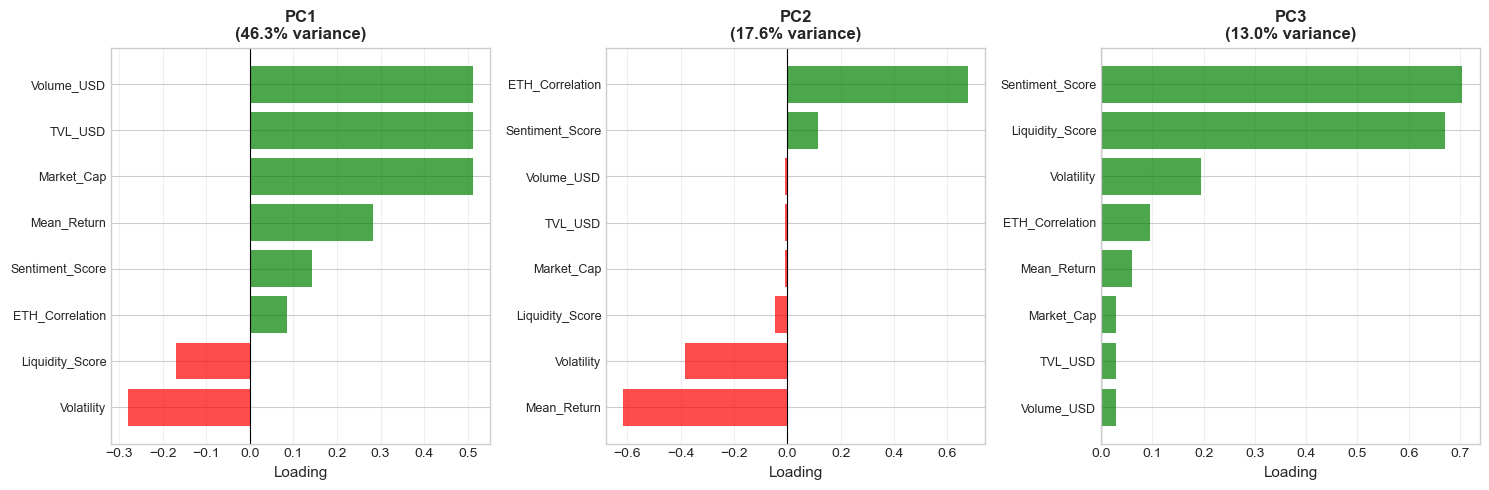


SUMMARY: NAMING OUR PRINCIPAL COMPONENTS


,Component,Variance,Top Features,Suggested Name
0,PC1,46.3%,"Volume_USD, TVL_USD, Market_Cap",Token Size/Liquidity
1,PC2,17.6%,"ETH_Correlation, Mean_Return, Volatility",Risk/Return Profile
2,PC3,13.0%,"Sentiment_Score, Liquidity_Score, Volatility",Risk/Return Profile



💡 Using These Interpretations:
   • PC1 (Size): Select tokens across different size categories
   • PC2 (Risk): Balance high-risk and low-risk tokens
   • PC3 (Exposure): Diversify market exposure



In [17]:
print("=" * 70)
print("ANALYZING PRINCIPAL COMPONENT LOADINGS")
print("=" * 70)

print("\n🔍 Loadings show how each original feature contributes to each PC")
print("   High |loading| = feature is important for that component")
print("   Sign indicates direction: + or -\n")

# Get the loadings matrix
loadings = pca_model.get_loadings()

print("📊 LOADINGS MATRIX:")
print("   (Rows = Features, Columns = Principal Components)")
print("=" * 70)
display(loadings.round(3))

print("\n💡 How to read this table:")
print("   • Values close to ±1.0 = STRONG relationship")
print("   • Values close to ±0.5 = MODERATE relationship")
print("   • Values close to 0.0 = WEAK/NO relationship")
print("   • Positive = feature increases with PC")
print("   • Negative = feature decreases with PC")

# Analyze each PC
print("\n" + "=" * 70)
print("INTERPRETING EACH PRINCIPAL COMPONENT")
print("=" * 70)

for i in range(min(3, loadings.shape[1])):  # Analyze first 3 PCs
    pc_name = f'PC{i+1}'
    pc_loadings = loadings[pc_name]
    
    print(f"\n{'='*70}")
    print(f"{pc_name} - {pca_model.pca.explained_variance_ratio_[i]:.1%} of variance")
    print('='*70)
    
    # Get top positive and negative loadings
    top_positive = pc_loadings.nlargest(3)
    top_negative = pc_loadings.nsmallest(3)
    
    print(f"\n🔺 Top POSITIVE loadings (features that increase with {pc_name}):")
    for feature, loading in top_positive.items():
        if loading > 0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    print(f"\n🔻 Top NEGATIVE loadings (features that decrease with {pc_name}):")
    for feature, loading in top_negative.items():
        if loading < -0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    # Suggest interpretation
    print(f"\n💭 Interpretation Hint:")
    
    # Analyze dominant features
    abs_loadings = pc_loadings.abs()
    dominant_features = abs_loadings[abs_loadings > 0.5].sort_values(ascending=False)
    
    if len(dominant_features) > 0:
        print(f"   Strong loadings on: {', '.join(dominant_features.index.tolist())}")
        
        # Pattern matching for common DeFi factors
        if any(feat in dominant_features.index for feat in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
            print(f"   → This looks like a SIZE/LIQUIDITY factor")
            print(f"   → Separates large established tokens from small new ones")
        
        if any(feat in dominant_features.index for feat in ['Volatility', 'Mean_Return']):
            print(f"   → This looks like a RISK/RETURN factor")
            print(f"   → Separates high-risk/high-return from stable tokens")
        
        if any(feat in dominant_features.index for feat in ['ETH_Correlation', 'Sentiment_Score']):
            print(f"   → This looks like a MARKET EXPOSURE factor")
            print(f"   → Separates market-following from independent tokens")
    else:
        print(f"   No dominant features - might be capturing residual variance")

print("\n" + "=" * 70)

# Create visual representation of loadings
print("\n📊 Creating loading visualizations...")
print("   Green bars = positive loadings (feature increases with PC)")
print("   Red bars = negative loadings (feature decreases with PC)")
print("   Length = strength of relationship\n")

fig = pca_model.plot_loadings(n_components=3, n_top_features=8, figsize=(15, 5))
plt.show()

print("\n" + "=" * 70)
print("SUMMARY: NAMING OUR PRINCIPAL COMPONENTS")
print("=" * 70)

# Create a summary table
pc_interpretations = []
for i in range(min(3, loadings.shape[1])):
    pc_name = f'PC{i+1}'
    variance = pca_model.pca.explained_variance_ratio_[i]
    
    # Get dominant features
    pc_loadings = loadings[pc_name]
    top_features = pc_loadings.abs().nlargest(3)
    
    # Suggest a name based on features
    feature_list = top_features.index.tolist()
    if any(f in feature_list for f in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
        suggested_name = "Token Size/Liquidity"
    elif any(f in feature_list for f in ['Volatility', 'Mean_Return']):
        suggested_name = "Risk/Return Profile"
    elif any(f in feature_list for f in ['ETH_Correlation', 'Sentiment_Score']):
        suggested_name = "Market Exposure"
    else:
        suggested_name = "Mixed Factor"
    
    pc_interpretations.append({
        'Component': pc_name,
        'Variance': f"{variance:.1%}",
        'Top Features': ', '.join(feature_list),
        'Suggested Name': suggested_name
    })

interpretation_df = pd.DataFrame(pc_interpretations)
display(interpretation_df)

print("\n💡 Using These Interpretations:")
print("   • PC1 (Size): Select tokens across different size categories")
print("   • PC2 (Risk): Balance high-risk and low-risk tokens")
print("   • PC3 (Exposure): Diversify market exposure")

print("\n" + "=" * 70)

In [18]:
class SimpleKMeans:
    """
    K-Means Clustering for DeFi Portfolio Segmentation
    
    This class wraps sklearn's KMeans with helpful methods for:
    - Finding optimal number of clusters
    - Fitting K-Means to DeFi data
    - Analyzing cluster characteristics
    - Visualizing clusters
    - Interpreting results for portfolio decisions
    """
    
    def __init__(self, n_clusters=3, random_state=42):
        """
        Initialize K-Means
        
        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters (k)
            - Start with 3-5 for portfolio segmentation
            - Use elbow method to find optimal value
        random_state : int, default=42
            Random seed for reproducibility
            - Same seed = same results every time
            - Important for comparing different runs
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scaler = StandardScaler()  # For standardizing features
        self.kmeans = None  # Will hold the fitted KMeans model
        self.feature_names = None  # To remember feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit K-Means model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (CRITICAL!)
        # Without this, features with large values dominate
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit K-Means
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10  # Run algorithm 10 times, keep best result
        )
        self.kmeans.fit(X_scaled)
        
        # Step 3: Save feature names
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ K-Means fitted successfully!")
        print(f"   Number of clusters: {self.n_clusters}")
        print(f"   Inertia (within-cluster sum of squares): {self.kmeans.inertia_:.2f}")
        print(f"   Lower inertia = tighter clusters")
        
        return self
    
    def predict(self, X):
        """
        Assign clusters to new data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            New tokens to classify
        
        Returns:
        --------
        labels : array, shape (n_samples,)
            Cluster assignments (0, 1, 2, ...)
        """
        X_scaled = self.scaler.transform(X)
        return self.kmeans.predict(X_scaled)
    
    def fit_predict(self, X, feature_names=None):
        """
        Fit K-Means and predict clusters in one step
        
        Convenience method combining fit() and predict()
        """
        self.fit(X, feature_names)
        return self.kmeans.labels_
    
    def get_cluster_centers(self):
        """
        Get cluster centroids in original feature scale
        
        Returns:
        --------
        DataFrame with clusters as rows, features as columns
        Shows the "average token" in each cluster
        """
        # Get centroids from scaled space
        centers_scaled = self.kmeans.cluster_centers_
        
        # Transform back to original scale
        centers = self.scaler.inverse_transform(centers_scaled)
        
        df = pd.DataFrame(
            centers,
            columns=self.feature_names if self.feature_names else range(centers.shape[1]),
            index=[f'Cluster_{i}' for i in range(self.n_clusters)]
        )
        
        return df
    
    def get_cluster_summary(self, X):
        """
        Get summary statistics for each cluster
        
        Returns:
        --------
        DataFrame with cluster sizes and percentages
        """
        clusters = self.kmeans.labels_
        
        summary = []
        for i in range(self.n_clusters):
            mask = clusters == i
            summary.append({
                'Cluster': i,
                'Size': mask.sum(),
                'Percentage': f"{100 * mask.sum() / len(clusters):.1f}%"
            })
        
        return pd.DataFrame(summary)
    
    def plot_elbow(self, X, max_k=10, figsize=(12, 5)):
        """
        Create elbow plot to find optimal number of clusters
        
        The "elbow method" helps choose k by showing:
        - Left plot: Inertia vs k (look for elbow)
        - Right plot: Silhouette score vs k (higher is better)
        
        Parameters:
        -----------
        X : array-like
            Data to cluster
        max_k : int, default=10
            Maximum number of clusters to test
        """
        X_scaled = self.scaler.fit_transform(X)
        
        inertias = []
        silhouettes = []
        K_range = range(2, max_k + 1)
        
        print(f"\n🔄 Testing different numbers of clusters (k = 2 to {max_k})...")
        print("   This may take a moment...\n")
        
        for k in K_range:
            # Fit K-Means with k clusters
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(X_scaled)
            
            # Calculate metrics
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
            
            print(f"   k={k}: inertia={kmeans.inertia_:>8.2f}, silhouette={silhouettes[-1]:>6.3f}")
        
        print("\n✅ Testing complete!\n")
        
        # Create plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left: Elbow plot (Inertia)
        axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12)
        axes[0].set_title('Elbow Method\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Mark potential elbow
        inertia_diffs = np.diff(inertias)
        elbow_k = np.argmax(np.diff(inertia_diffs)) + 2  # +2 due to double diff
        axes[0].axvline(x=elbow_k, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Potential elbow at k={elbow_k}')
        axes[0].legend()
        
        # Right: Silhouette Score
        axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
        axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[1].set_ylabel('Silhouette Score', fontsize=12)
        axes[1].set_title('Silhouette Score\n(Higher is better)', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Mark best silhouette
        best_k = K_range[np.argmax(silhouettes)]
        axes[1].axvline(x=best_k, color='green', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Best silhouette at k={best_k}')
        axes[1].legend()
        
        plt.tight_layout()
        return fig
    
    def plot_clusters_2d(self, X_2d, labels=None, figsize=(10, 8)):
        """
        Plot clusters in 2D space (after dimensionality reduction)
        
        Parameters:
        -----------
        X_2d : array-like, shape (n_samples, 2)
            2D representation of data (e.g., from PCA)
        labels : list of str, optional
            Token names for annotation
        """
        clusters = self.kmeans.labels_
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Use distinct colors for each cluster
        colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
        
        # Plot each cluster separately
        for i in range(self.n_clusters):
            mask = clusters == i
            ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                      c=[colors[i]], label=f'Cluster {i}',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add labels to some points (not all, to avoid clutter)
        if labels is not None:
            step = max(1, len(labels)//20)  # Label ~20 points
            for i in range(0, len(labels), step):
                ax.annotate(labels[i], (X_2d[i, 0], X_2d[i, 1]),
                          fontsize=8, alpha=0.7)
        
        ax.set_xlabel('Dimension 1', fontsize=12, fontweight='bold')
        ax.set_ylabel('Dimension 2', fontsize=12, fontweight='bold')
        ax.set_title(f'K-Means Clustering ({self.n_clusters} clusters)', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimpleKMeans class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit K-Means to data")
print("  • predict(X) - Assign clusters to new tokens")
print("  • fit_predict(X, feature_names) - Fit and predict in one step")
print("  • get_cluster_centers() - Get centroid characteristics")
print("  • get_cluster_summary(X) - Get cluster sizes")
print("  • plot_elbow(X, max_k) - Find optimal number of clusters")
print("  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D")
print("=" * 70)

✅ SimpleKMeans class created successfully!

Available methods:
  • fit(X, feature_names) - Fit K-Means to data
  • predict(X) - Assign clusters to new tokens
  • fit_predict(X, feature_names) - Fit and predict in one step
  • get_cluster_centers() - Get centroid characteristics
  • get_cluster_summary(X) - Get cluster sizes
  • plot_elbow(X, max_k) - Find optimal number of clusters
  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D


FINDING OPTIMAL NUMBER OF CLUSTERS — PCA-BASED K-MEANS

🎯 Goal: Determine the optimal k (number of clusters)
   We'll use the PCA-transformed data (3 components).
   Methods used:
   1. Elbow Method  → detects 'knee' in inertia drop
   2. Silhouette Score  → measures cluster quality

📊 Using PCA data with shape: (47, 3)

🔄 Testing different numbers of clusters (k = 2 to 10)...
   This may take a moment...

   k=2: inertia=  105.74, silhouette= 0.234
   k=3: inertia=   78.57, silhouette= 0.279
   k=4: inertia=   58.38, silhouette= 0.334
   k=5: inertia=   47.29, silhouette= 0.330
   k=6: inertia=   37.47, silhouette= 0.359
   k=7: inertia=   27.88, silhouette= 0.401
   k=8: inertia=   23.35, silhouette= 0.372
   k=9: inertia=   19.99, silhouette= 0.398
   k=10: inertia=   16.87, silhouette= 0.388

✅ Testing complete!



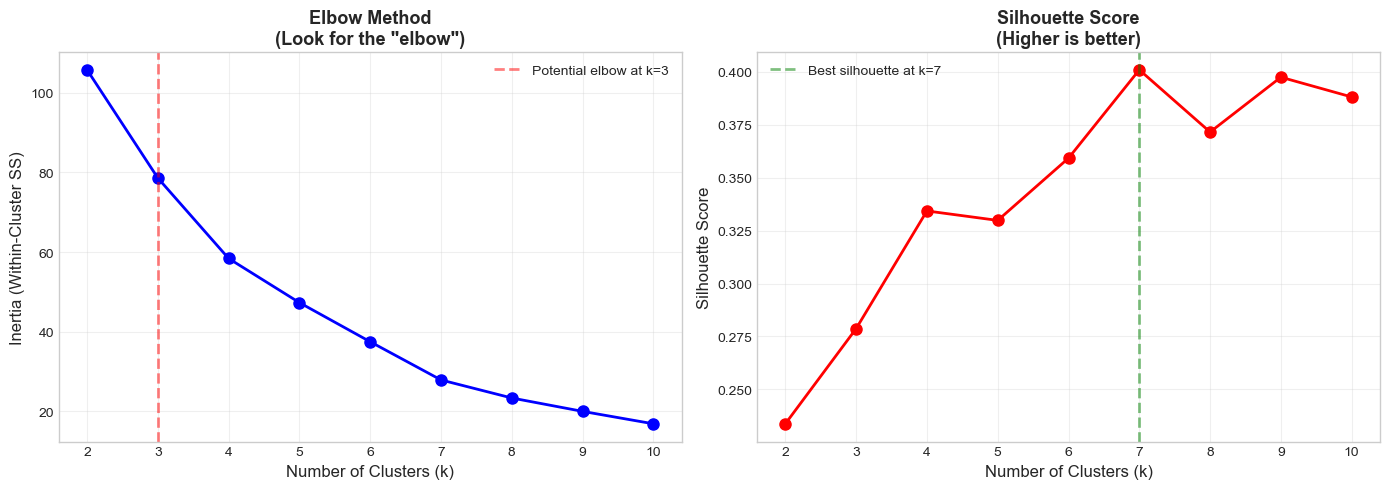


ANALYZING CLUSTER QUALITY

📈 Elbow Method → suggests k=3
🤝 Silhouette Method → suggests k=7 (score=0.401)

✅ Final Decision:
   Optimal number of clusters (k) = 7
   Reason: Silhouette preferred for cluster quality
   Silhouette Score = 0.401

✅ ELBOW ANALYSIS COMPLETE — OPTIMAL k = 7


In [19]:
# ==============================================================
#  STEP 1.3.1 — FINDING OPTIMAL NUMBER OF CLUSTERS (K-MEANS)
# ==============================================================

print("=" * 70)
print("FINDING OPTIMAL NUMBER OF CLUSTERS — PCA-BASED K-MEANS")
print("=" * 70)

print("\n🎯 Goal: Determine the optimal k (number of clusters)")
print("   We'll use the PCA-transformed data (3 components).")
print("   Methods used:")
print("   1. Elbow Method  → detects 'knee' in inertia drop")
print("   2. Silhouette Score  → measures cluster quality\n")

# ✅ Use PCA-transformed data (NOT raw features)
X_cluster = X_pca[:, :3]
print(f"📊 Using PCA data with shape: {X_cluster.shape}")

# Initialize temporary K-Means model
kmeans_temp = SimpleKMeans(n_clusters=3, random_state=42)

# Run elbow + silhouette analysis
fig = kmeans_temp.plot_elbow(X_cluster, max_k=10, figsize=(14, 5))
plt.show()

# ==============================================================
#  ANALYSIS OF RESULTS
# ==============================================================

print("\n" + "=" * 70)
print("ANALYZING CLUSTER QUALITY")
print("=" * 70)

# Recompute metrics numerically to extract best k
X_scaled = kmeans_temp.scaler.fit_transform(X_cluster)
inertias, silhouettes = [], []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Compute elbow (based on inertia 2nd derivative)
inertia_diffs = np.diff(inertias)
inertia_diffs2 = np.diff(inertia_diffs)
elbow_k = np.argmax(inertia_diffs2) + 2

# Find best silhouette score
best_silhouette_idx = np.argmax(silhouettes)
best_silhouette_k = list(K_range)[best_silhouette_idx]
best_silhouette_score = silhouettes[best_silhouette_idx]

print(f"\n📈 Elbow Method → suggests k={elbow_k}")
print(f"🤝 Silhouette Method → suggests k={best_silhouette_k} (score={best_silhouette_score:.3f})")

# Decide final k
if abs(elbow_k - best_silhouette_k) <= 1:
    optimal_k = best_silhouette_k
    reason = "Both methods consistent (±1)"
else:
    optimal_k = best_silhouette_k
    reason = "Silhouette preferred for cluster quality"

print("\n✅ Final Decision:")
print(f"   Optimal number of clusters (k) = {optimal_k}")
print(f"   Reason: {reason}")
print(f"   Silhouette Score = {silhouettes[optimal_k-2]:.3f}")

# Save optimal k for next step
print("\n" + "=" * 70)
print(f"✅ ELBOW ANALYSIS COMPLETE — OPTIMAL k = {optimal_k}")
print("=" * 70)

FITTING K-MEANS WITH OPTIMAL k=7

🔧 Initializing K-Means with k=7 clusters...
   This will:
   1. Standardize PCA components
   2. Run K-Means algorithm (may take a few seconds)
   3. Assign each token to a cluster
   4. Calculate cluster centroids


✅ K-Means fitted successfully!
   Number of clusters: 7
   Inertia (within-cluster sum of squares): 27.88
   Lower inertia = tighter clusters

CLUSTER ASSIGNMENT COMPLETE

✅ All 47 tokens assigned to 7 clusters

📊 CLUSTER DISTRIBUTION:


,Cluster,Size,Percentage
0,0,11,23.4%
1,1,2,4.3%
2,2,7,14.9%
3,3,8,17.0%
4,4,2,4.3%
5,5,3,6.4%
6,6,14,29.8%


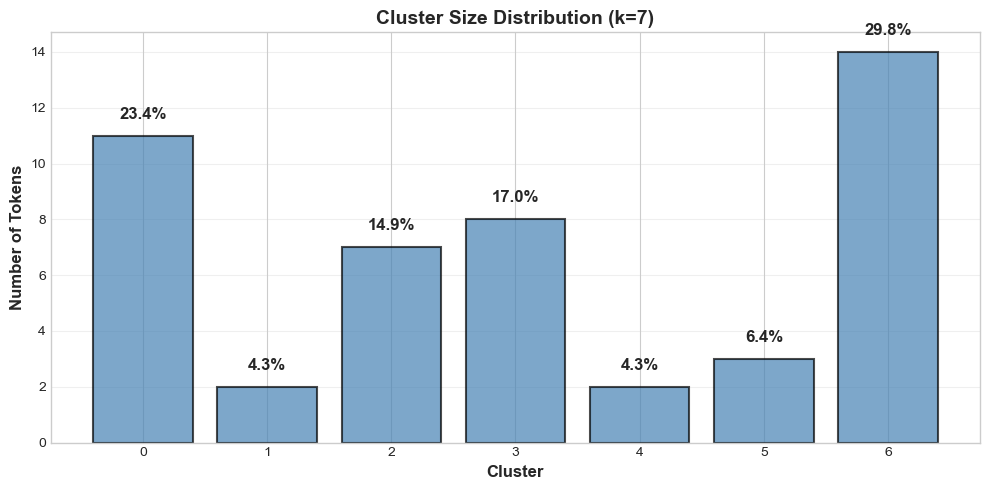


🔍 Balance Analysis:
   ⚠️  IMBALANCED: Largest cluster is 7.0x bigger than smallest

CLUSTER CHARACTERISTICS (CENTROIDS)

📋 Centroid Table (Average component values):


,PC1,PC2,PC3
Cluster_0,-0.287,-0.806,0.373
Cluster_1,5.572,2.074,0.087
Cluster_2,-1.100,-0.105,-1.629
Cluster_3,2.348,-0.144,-0.196
Cluster_4,0.587,-3.637,-0.231
Cluster_5,0.249,0.275,2.216
Cluster_6,-1.499,0.932,0.180



🎯 Most distinguishing components between clusters:

   1. PC3        (variation: 9.96)
   2. PC2        (variation: 8.80)
   3. PC1        (variation: 2.90)

💡 Interpretation:
   • If PC1 differs most → clusters differ mainly by SIZE/LIQUIDITY
   • If PC2 differs most → clusters differ by RISK/RETURN
   • If PC3 differs most → clusters differ by MARKET EXPOSURE

DETAILED CLUSTER ANALYSIS (in PCA space)

Cluster 0: 11 tokens (23.4%)
   Mean PC1=-0.287, PC2=-0.806, PC3=0.373
   → Mixed or transitional group
   Sample tokens: AAVE-USD, NEAR-USD, FIL-USD, SAND-USD, XLM-USD, CAKE-USD

Cluster 1: 2 tokens (4.3%)
   Mean PC1=5.572, PC2=2.074, PC3=0.087
   → Mixed or transitional group
   Sample tokens: BTC-USD, ETH-USD

Cluster 2: 7 tokens (14.9%)
   Mean PC1=-1.100, PC2=-0.105, PC3=-1.629
   → Mixed or transitional group
   Sample tokens: SNX-USD, CRV-USD, BAT-USD, QTUM-USD, WAVES-USD, XTZ-USD

Cluster 3: 8 tokens (17.0%)
   Mean PC1=2.348, PC2=-0.144, PC3=-0.196
   → Likely Large-cap / Sta

In [20]:
print("=" * 70)
print(f"FITTING K-MEANS WITH OPTIMAL k={optimal_k}")
print("=" * 70)

print(f"\n🔧 Initializing K-Means with k={optimal_k} clusters...")
print("   This will:")
print("   1. Standardize PCA components")
print("   2. Run K-Means algorithm (may take a few seconds)")
print("   3. Assign each token to a cluster")
print("   4. Calculate cluster centroids\n")

# Initialize K-Means with optimal k
kmeans_model = SimpleKMeans(n_clusters=optimal_k, random_state=42)

# ✅ Fit K-Means on PCA data (3 components)
clusters = kmeans_model.fit_predict(
    X_pca[:, :3],
    feature_names=[f"PC{i+1}" for i in range(3)]
)

print("\n" + "=" * 70)
print("CLUSTER ASSIGNMENT COMPLETE")
print("=" * 70)

# Add cluster labels to tokens
defi_data_clustered = defi_data.copy()
defi_data_clustered['Cluster'] = clusters

print(f"\n✅ All {len(defi_data)} tokens assigned to {optimal_k} clusters")

# ✅ Get cluster summary
cluster_summary = kmeans_model.get_cluster_summary(X_pca[:, :3])

print("\n📊 CLUSTER DISTRIBUTION:")
print("=" * 70)
display(cluster_summary)

# Bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(cluster_summary['Cluster'], cluster_summary['Size'], 
              alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)

for i, (idx, row) in enumerate(cluster_summary.iterrows()):
    ax.text(row['Cluster'], row['Size'] + 0.5, row['Percentage'], 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Tokens', fontsize=12, fontweight='bold')
ax.set_title(f'Cluster Size Distribution (k={optimal_k})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(cluster_summary['Cluster'])

plt.tight_layout()
plt.show()

# Balance analysis
print("\n🔍 Balance Analysis:")
max_size = cluster_summary['Size'].max()
min_size = cluster_summary['Size'].min()
size_ratio = max_size / min_size

if size_ratio > 5:
    print(f"   ⚠️  IMBALANCED: Largest cluster is {size_ratio:.1f}x bigger than smallest")
elif size_ratio > 2.5:
    print(f"   ⚠️  SOMEWHAT IMBALANCED: Size ratio is {size_ratio:.1f}x")
else:
    print(f"   ✅ WELL BALANCED: Size ratio is {size_ratio:.1f}x")

print("\n" + "=" * 70)
print("CLUSTER CHARACTERISTICS (CENTROIDS)")
print("=" * 70)

# ✅ Centroids in PCA space
centroids = kmeans_model.get_cluster_centers()

print("\n📋 Centroid Table (Average component values):")
display(centroids.round(3))

# Variability per PC
feature_cv = centroids.std() / (centroids.mean().abs() + 1e-10)
distinguishing_features = feature_cv.sort_values(ascending=False)

print("\n🎯 Most distinguishing components between clusters:\n")
for i, (feature, cv) in enumerate(distinguishing_features.head(3).items(), 1):
    print(f"   {i}. {feature:10s} (variation: {cv:.2f})")

print("\n💡 Interpretation:")
print("   • If PC1 differs most → clusters differ mainly by SIZE/LIQUIDITY")
print("   • If PC2 differs most → clusters differ by RISK/RETURN")
print("   • If PC3 differs most → clusters differ by MARKET EXPOSURE")

print("\n" + "=" * 70)
print("DETAILED CLUSTER ANALYSIS (in PCA space)")
print("=" * 70)

for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i]
    print(f"\nCluster {i}: {len(cluster_data)} tokens ({len(cluster_data)/len(defi_data)*100:.1f}%)")
    
    # PCA averages
    centroid_vals = centroids.iloc[i]
    print(f"   Mean PC1={centroid_vals['PC1']:.3f}, PC2={centroid_vals['PC2']:.3f}, PC3={centroid_vals['PC3']:.3f}")
    
    if centroid_vals['PC1'] > 0 and centroid_vals['PC2'] < 0:
        print("   → Likely Large-cap / Stable tokens")
    elif centroid_vals['PC1'] < 0 and centroid_vals['PC2'] > 0:
        print("   → Smaller / More volatile tokens")
    else:
        print("   → Mixed or transitional group")

    print(f"   Sample tokens: {', '.join(cluster_data.index[:6])}")

print("\n" + "=" * 70)
print("✅ CLUSTER ANALYSIS COMPLETE")
print("=" * 70)
print(f"\n🎯 Tokens successfully segmented into {optimal_k} clusters using PCA space.")
print("   Each cluster represents a distinct DeFi token profile (size, volatility, exposure).")

VISUALIZING CLUSTERS IN 2D SPACE

📊 Challenge: Tokens exist in multi-dimensional DeFi feature space
   Solution: Use PCA to project data into 2D for visualization

🔧 Process:
   1. Apply PCA → reduce 8 features → 2 components
   2. Plot tokens using PC1 (x-axis) & PC2 (y-axis)
   3. Color by K-Means cluster
   4. Analyze cluster separation, outliers, and quadrants

Step 1: Applying PCA for 2D projection...

✅ PCA fitted successfully!
   Components: 2
   Total variance explained: 63.92%
   ✅ PCA complete!
   • PC1 explains: 46.3%
   • PC2 explains: 17.6%
   • Total variance captured in 2D: 63.9%
   ✅ Good: 63.9% variance visible in 2D

📊 Understanding PCA Axes (Feature Loadings):

PC1 (X-axis) strongest features:
   • Volume_USD: +0.512
   • TVL_USD: +0.512
   • Market_Cap: +0.512

PC2 (Y-axis) strongest features:
   • ETH_Correlation: +0.677
   • Mean_Return: -0.615
   • Volatility: -0.384

Step 2: Creating 2D cluster visualization


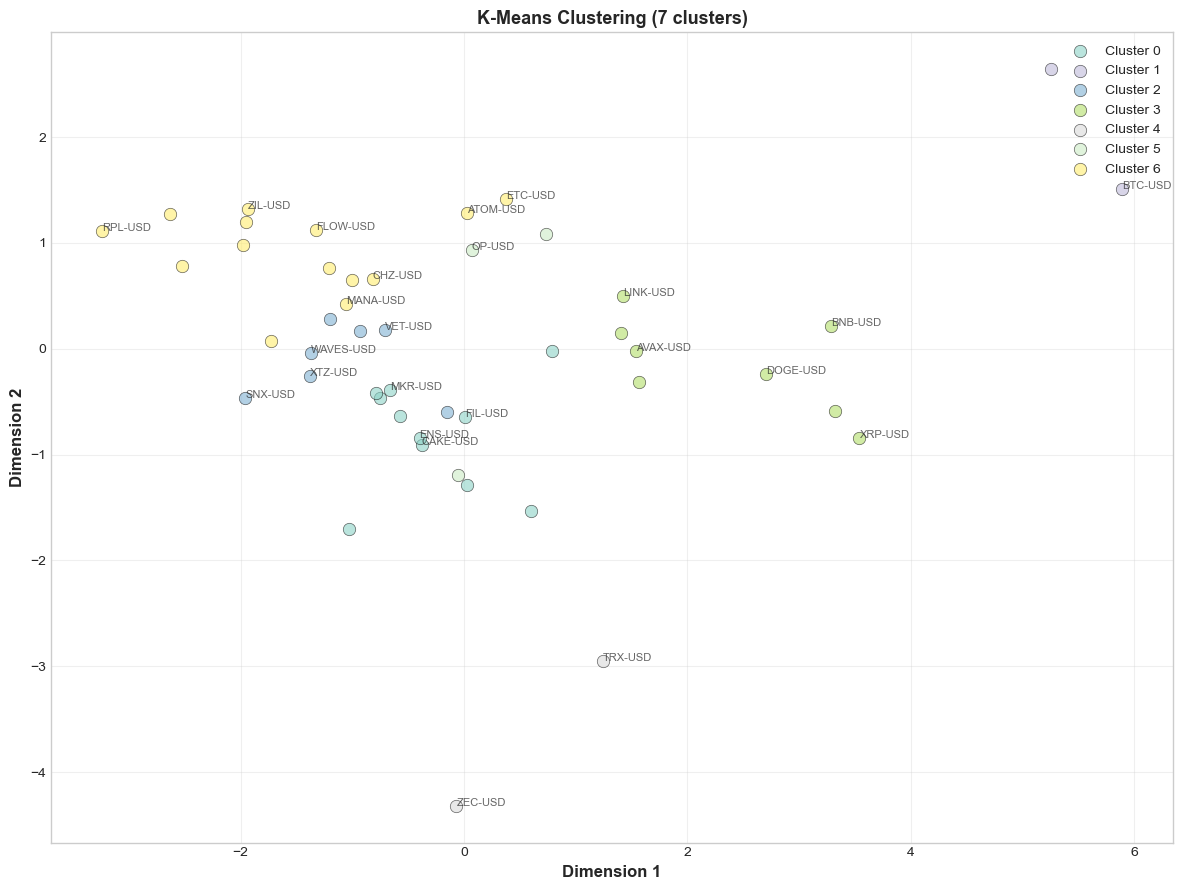


ANALYZING CLUSTER STRUCTURE IN 2D SPACE

Cluster 0: (11 tokens)
   Center: PC1=-0.29, PC2=-0.81
   Spread: PC1±0.56, PC2±0.49

Cluster 1: (2 tokens)
   Center: PC1=+5.57, PC2=+2.07
   Spread: PC1±0.32, PC2±0.57

Cluster 2: (7 tokens)
   Center: PC1=-1.10, PC2=-0.10
   Spread: PC1±0.53, PC2±0.32

Cluster 3: (8 tokens)
   Center: PC1=+2.35, PC2=-0.14
   Spread: PC1±0.89, PC2±0.41

Cluster 4: (2 tokens)
   Center: PC1=+0.59, PC2=-3.64
   Spread: PC1±0.66, PC2±0.68

Cluster 5: (3 tokens)
   Center: PC1=+0.25, PC2=+0.27
   Spread: PC1±0.35, PC2±1.04

Cluster 6: (14 tokens)
   Center: PC1=-1.50, PC2=+0.93
   Spread: PC1±0.96, PC2±0.38

📏 Cluster center distances (Euclidean):
   Cluster 0 ↔ Cluster 1: 6.53
   Cluster 0 ↔ Cluster 2: 1.07
   Cluster 0 ↔ Cluster 3: 2.72
   Cluster 0 ↔ Cluster 4: 2.96
   Cluster 0 ↔ Cluster 5: 1.21
   Cluster 0 ↔ Cluster 6: 2.12
   Cluster 1 ↔ Cluster 2: 7.02
   Cluster 1 ↔ Cluster 3: 3.91
   Cluster 1 ↔ Cluster 4: 7.58
   Cluster 1 ↔ Cluster 5: 5.62
   Cluster 

In [21]:
# ==============================================================
#  STEP 1.4 — VISUALIZING CLUSTERS IN 2D SPACE (PCA PROJECTION)
# ==============================================================

print("=" * 70)
print("VISUALIZING CLUSTERS IN 2D SPACE")
print("=" * 70)

print("\n📊 Challenge: Tokens exist in multi-dimensional DeFi feature space")
print("   Solution: Use PCA to project data into 2D for visualization\n")

print("🔧 Process:")
print("   1. Apply PCA → reduce 8 features → 2 components")
print("   2. Plot tokens using PC1 (x-axis) & PC2 (y-axis)")
print("   3. Color by K-Means cluster")
print("   4. Analyze cluster separation, outliers, and quadrants\n")

# --------------------------------------------------------------
# Step 1: Apply PCA for 2D visualization
# --------------------------------------------------------------
print("Step 1: Applying PCA for 2D projection...")

pca_2d = SimplePCA(n_components=2)
X_2d = pca_2d.fit_transform(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

# Variance explained
var_pc1 = pca_2d.pca.explained_variance_ratio_[0]
var_pc2 = pca_2d.pca.explained_variance_ratio_[1]
total_var_2d = var_pc1 + var_pc2

print(f"   ✅ PCA complete!")
print(f"   • PC1 explains: {var_pc1:.1%}")
print(f"   • PC2 explains: {var_pc2:.1%}")
print(f"   • Total variance captured in 2D: {total_var_2d:.1%}")

if total_var_2d < 0.50:
    print(f"   ⚠️  Only {total_var_2d:.1%} variance shown — higher dimensions matter")
elif total_var_2d < 0.70:
    print(f"   ✅ Good: {total_var_2d:.1%} variance visible in 2D")
else:
    print(f"   ✅ Excellent: {total_var_2d:.1%} variance captured")

# --------------------------------------------------------------
# Step 2: Interpret PCA axes
# --------------------------------------------------------------
print("\n📊 Understanding PCA Axes (Feature Loadings):")
loadings_2d = pca_2d.get_loadings()

print("\nPC1 (X-axis) strongest features:")
for feature in loadings_2d['PC1'].abs().nlargest(3).index:
    print(f"   • {feature}: {loadings_2d.loc[feature, 'PC1']:+.3f}")

print("\nPC2 (Y-axis) strongest features:")
for feature in loadings_2d['PC2'].abs().nlargest(3).index:
    print(f"   • {feature}: {loadings_2d.loc[feature, 'PC2']:+.3f}")

# --------------------------------------------------------------
# Step 3: Visualize clusters in 2D
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("Step 2: Creating 2D cluster visualization")
print("=" * 70)

fig = kmeans_model.plot_clusters_2d(
    X_2d,
    labels=defi_data.index.tolist(),
    figsize=(12, 9)
)
plt.show()

# --------------------------------------------------------------
# Step 4: Analyze clusters in 2D
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("ANALYZING CLUSTER STRUCTURE IN 2D SPACE")
print("=" * 70)

clusters = kmeans_model.kmeans.labels_

from scipy.spatial.distance import pdist, squareform

for i in range(optimal_k):
    mask = clusters == i
    cluster_points = X_2d[mask]
    center = cluster_points.mean(axis=0)
    spread = cluster_points.std(axis=0)
    print(f"\nCluster {i}: ({len(cluster_points)} tokens)")
    print(f"   Center: PC1={center[0]:+.2f}, PC2={center[1]:+.2f}")
    print(f"   Spread: PC1±{spread[0]:.2f}, PC2±{spread[1]:.2f}")

# Distances between cluster centers
centers_2d = np.array([
    X_2d[clusters == i].mean(axis=0)
    for i in range(optimal_k)
])
distances = squareform(pdist(centers_2d))
print("\n📏 Cluster center distances (Euclidean):")
for i in range(optimal_k):
    for j in range(i + 1, optimal_k):
        print(f"   Cluster {i} ↔ Cluster {j}: {distances[i, j]:.2f}")

avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()
print(f"\nAverage separation: {avg_sep:.2f}")

if avg_sep > 3.0:
    print("   ✅ Excellent separation")
elif avg_sep > 2.0:
    print("   ✅ Good separation")
elif avg_sep > 1.0:
    print("   ⚠️  Moderate overlap")
else:
    print("   ⚠️  Poor separation")

# --------------------------------------------------------------
# Step 5: Detect potential outliers
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("OUTLIER DETECTION")
print("=" * 70)

outliers = []
for i in range(optimal_k):
    mask = clusters == i
    points = X_2d[mask]
    tokens = defi_data.index[mask]
    center = points.mean(axis=0)
    dists = np.sqrt(((points - center)**2).sum(axis=1))
    threshold = dists.mean() + 2.5 * dists.std()
    for t, dist in zip(tokens[dists > threshold], dists[dists > threshold]):
        outliers.append({'Token': t, 'Cluster': i, 'Distance': dist})

if outliers:
    outliers_df = pd.DataFrame(outliers).sort_values('Distance', ascending=False)
    print(f"Found {len(outliers_df)} potential outliers:")
    display(outliers_df.head(10))
else:
    print("✅ No significant outliers detected.")

# --------------------------------------------------------------
# Step 6: Quadrant analysis
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("QUADRANT ANALYSIS (PC1 vs PC2)")
print("=" * 70)

quadrants = {
    'High PC1 & High PC2': (X_2d[:, 0] > 0) & (X_2d[:, 1] > 0),
    'Low PC1 & High PC2': (X_2d[:, 0] < 0) & (X_2d[:, 1] > 0),
    'Low PC1 & Low PC2': (X_2d[:, 0] < 0) & (X_2d[:, 1] < 0),
    'High PC1 & Low PC2': (X_2d[:, 0] > 0) & (X_2d[:, 1] < 0)
}

for name, mask in quadrants.items():
    print(f"   {name:20s}: {mask.sum():2d} tokens ({mask.sum()/len(defi_data)*100:4.1f}%)")

print("\n📘 Interpretation:")
print("   • High PC1, High PC2 → Large & Risky tokens")
print("   • Low PC1, High PC2  → Small & Risky tokens")
print("   • Low PC1, Low PC2   → Small & Stable tokens")
print("   • High PC1, Low PC2  → Large & Stable tokens")

# --------------------------------------------------------------
# Step 7: Summary validation
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("VISUAL VALIDATION SUMMARY")
print("=" * 70)

summary_checks = {
    "Cluster separation": avg_sep > 1.5,
    "Cluster balance": cluster_summary['Size'].std() < len(defi_data) * 0.2,
    "Variance coverage": total_var_2d > 0.5,
    "Few outliers": len(outliers) < len(defi_data) * 0.1
}

for k, ok in summary_checks.items():
    symbol = "✅" if ok else "⚠️ "
    print(f"   {symbol} {k}")

if all(summary_checks.values()):
    print("\n✅ OVERALL: Clustering looks GOOD — well-separated and interpretable")
else:
    print("\n⚠️  OVERALL: Clustering acceptable but needs review (overlap or imbalance)")

print("\n" + "=" * 70)
print("✅ 2D Visualization & Analysis Complete")
print("=" * 70)


BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO

🎯 Portfolio Construction Strategy:
   • Method: Quality-weighted selection using Sharpe ratio
   • Tokens per cluster: 2
   • Weighting: Equal weight across selected tokens
   • Goal: Diversify across clusters while maximizing risk-adjusted returns

Step 1: Calculating Sharpe ratio for all tokens...
   ✅ Sharpe ratios calculated

📊 Sharpe Ratio Distribution:
   Mean:      0.352
   Median:    0.310
   Min:      -0.463
   Max:       1.574

Step 2: Selecting top tokens from each cluster...

Cluster 0 (11 tokens):
   1. XLM-USD          Sharpe=+0.739 (Return=0.5836, Vol=0.7903)
   2. AAVE-USD         Sharpe=+0.708 (Return=0.5740, Vol=0.8103)

Cluster 1 (2 tokens):
   1. BTC-USD          Sharpe=+1.089 (Return=0.4387, Vol=0.4027)
   2. ETH-USD          Sharpe=+0.574 (Return=0.3328, Vol=0.5801)

Cluster 2 (7 tokens):
   1. CRV-USD          Sharpe=+0.423 (Return=0.3981, Vol=0.9415)
   2. BAT-USD          Sharpe=+0.369 (Return=0.2663, Vol=0.7222)


,Token,Cluster,Mean_Return,Volatility,Sharpe_Ratio,Market_Cap,Liquidity_Score
0,XLM-USD,0,0.583631,0.790269,0.738521,21.943318,75.292669
1,AAVE-USD,0,0.573985,0.810328,0.708337,21.864084,50.285708
2,BTC-USD,1,0.438684,0.402666,1.089449,26.777252,43.021323
3,ETH-USD,1,0.332778,0.580061,0.573694,26.149320,27.078150
4,CRV-USD,2,0.398051,0.941508,0.422780,21.204515,9.471430
5,BAT-USD,2,0.266262,0.722173,0.368695,19.558187,4.408235
6,BNB-USD,3,0.583366,0.469740,1.241892,23.750162,21.949726
7,SOL-USD,3,0.714373,0.746880,0.956476,24.508971,25.452708
8,ZEC-USD,4,1.475921,0.937701,1.573978,20.943549,76.621150
9,TRX-USD,4,0.544447,0.669201,0.813578,22.569124,35.857845



💰 Portfolio Weights:


,Token,Cluster,Weight_Pct
0,XLM-USD,0,7.142857
1,AAVE-USD,0,7.142857
2,BTC-USD,1,7.142857
3,ETH-USD,1,7.142857
4,CRV-USD,2,7.142857
5,BAT-USD,2,7.142857
6,BNB-USD,3,7.142857
7,SOL-USD,3,7.142857
8,ZEC-USD,4,7.142857
9,TRX-USD,4,7.142857



📈 Portfolio Performance Summary:
   Expected Daily Return:     0.4991 (49.91%)
   Expected Daily Volatility: 0.1997 (19.97%)
   Portfolio Sharpe Ratio:    2.500

📊 Annualized Estimates:
   Annual Return:     12577.74%
   Annual Volatility:  316.97%
   Annual Sharpe:        2.500

📘 Benchmark (Equal-weight): Sharpe=0.339
   ✅ Our portfolio Sharpe is +2.160 better (+636.4%)

📊 Portfolio Composition by Cluster:


,Num_Tokens,Weight,Mean_Return,Volatility,Sharpe_Ratio,Weight_Pct
Cluster,,,,,,
0,2,0.1429,0.5788,0.8003,0.7234,14.2857
1,2,0.1429,0.3857,0.4914,0.8316,14.2857
2,2,0.1429,0.3322,0.8318,0.3957,14.2857
3,2,0.1429,0.6489,0.6083,1.0992,14.2857
4,2,0.1429,1.0102,0.8035,1.1938,14.2857
5,2,0.1429,0.3563,0.7966,0.4181,14.2857
6,2,0.1429,0.1818,0.7795,0.2363,14.2857



VISUALIZATIONS


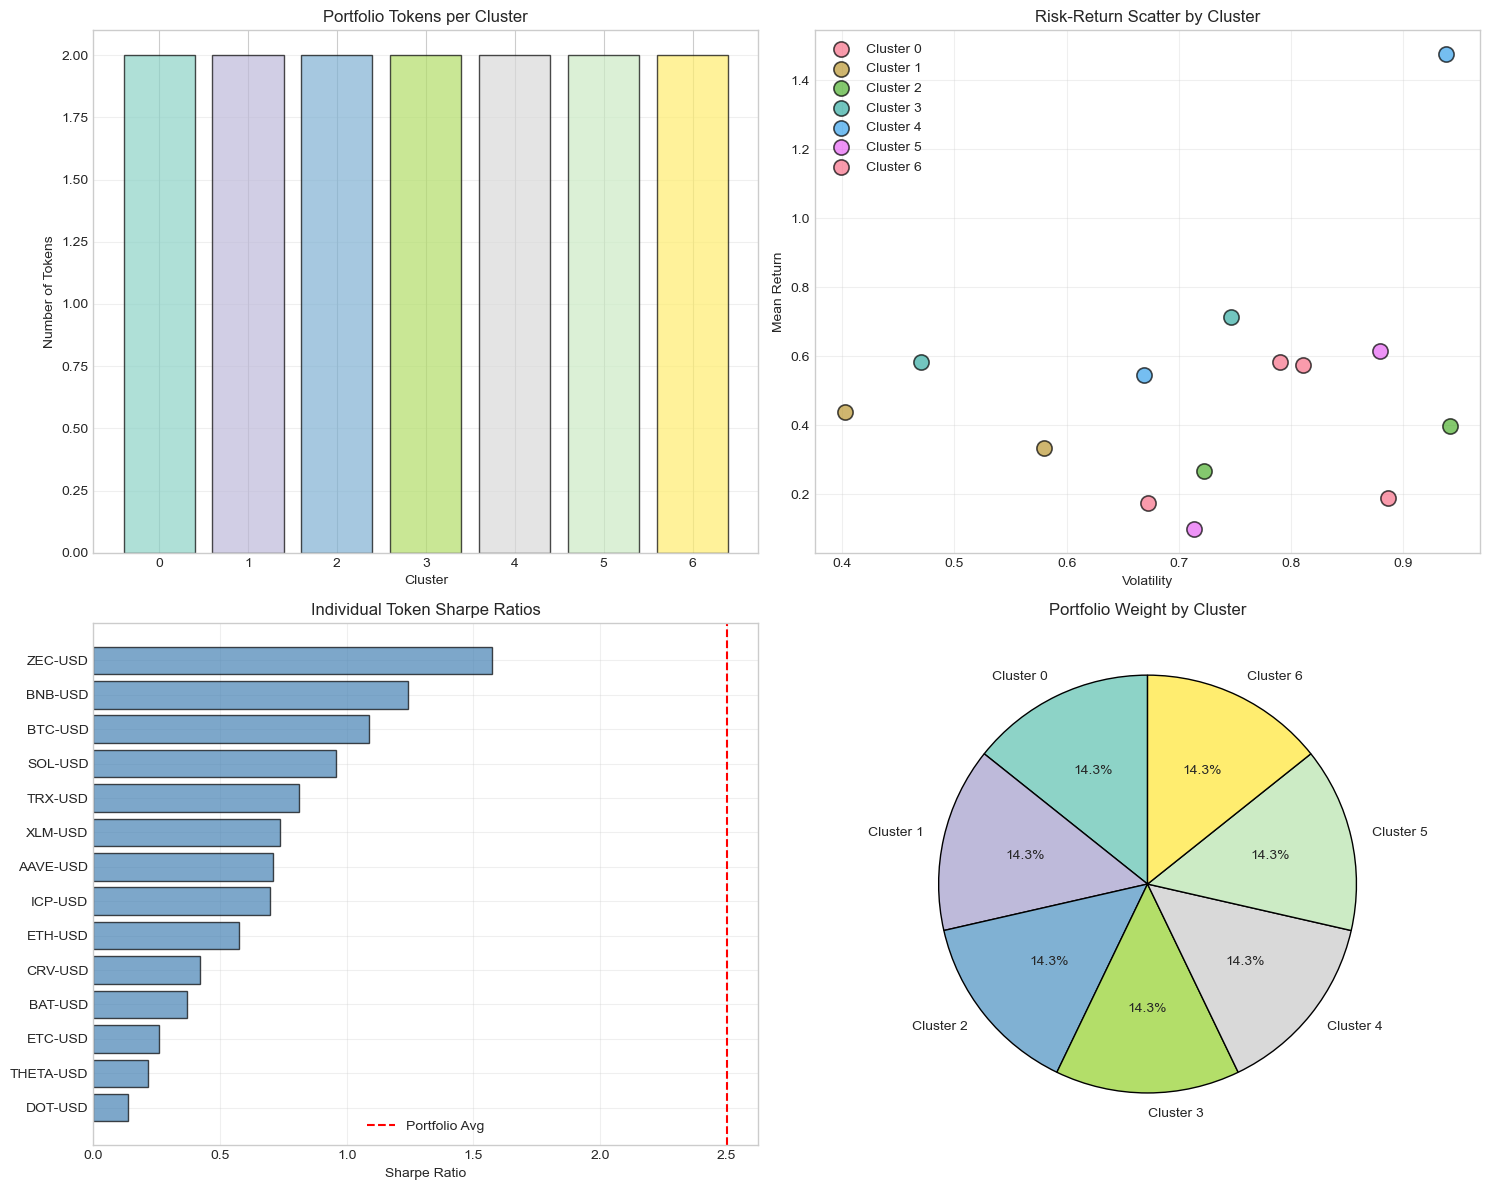


PORTFOLIO RECOMMENDATIONS

   Risk profile: 🛡️ CONSERVATIVE
   Portfolio Volatility: 0.1997
   Market Average Volatility: 0.7925

💡 Recommendations:
   1️⃣ Rebalance monthly or when weights drift >5%
   2️⃣ Monitor token & cluster performance
   3️⃣ Track Sharpe ratio trends
   4️⃣ Investigate cluster concentration risks

   Cluster concentration index: 0.143
   ✅ Well diversified

✅ Portfolio Construction Complete

📋 FINAL SUMMARY:
   • Total tokens: 14
   • Clusters represented: 7
   • Annualized Return: 12577.74%
   • Annualized Volatility: 316.97%
   • Sharpe Ratio: 2.500


In [22]:
# ==============================================================
#  STEP 1.5 — BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO
# ==============================================================

print("=" * 70)
print("BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO")
print("=" * 70)

print("\n🎯 Portfolio Construction Strategy:")
print("   • Method: Quality-weighted selection using Sharpe ratio")
print("   • Tokens per cluster: 2")
print("   • Weighting: Equal weight across selected tokens")
print("   • Goal: Diversify across clusters while maximizing risk-adjusted returns\n")

# --------------------------------------------------------------
# Step 1: Calculate Sharpe Ratio
# --------------------------------------------------------------
print("Step 1: Calculating Sharpe ratio for all tokens...")

if 'Mean_Return' not in defi_data_clustered.columns or 'Volatility' not in defi_data_clustered.columns:
    raise ValueError("⚠️ Columns 'Mean_Return' and 'Volatility' must exist in defi_data_clustered.")

defi_data_clustered['Sharpe_Ratio'] = (
    defi_data_clustered['Mean_Return'] / (defi_data_clustered['Volatility'] + 1e-10)
)

print("   ✅ Sharpe ratios calculated\n")

# Summary statistics
print("📊 Sharpe Ratio Distribution:")
sharpe_stats = defi_data_clustered['Sharpe_Ratio'].describe()
print(f"   Mean:   {sharpe_stats['mean']:>8.3f}")
print(f"   Median: {sharpe_stats['50%']:>8.3f}")
print(f"   Min:    {sharpe_stats['min']:>8.3f}")
print(f"   Max:    {sharpe_stats['max']:>8.3f}")

# --------------------------------------------------------------
# Step 2: Select top tokens per cluster
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("Step 2: Selecting top tokens from each cluster...")
print("=" * 70)

tokens_per_cluster = 2
portfolio = []

for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i].copy()
    if cluster_data.empty:
        continue

    print(f"\nCluster {i} ({len(cluster_data)} tokens):")

    # Sort by Sharpe ratio (descending)
    cluster_data_sorted = cluster_data.sort_values('Sharpe_Ratio', ascending=False)
    selected = cluster_data_sorted.head(tokens_per_cluster)

    for idx, token in enumerate(selected.index):
        t = selected.loc[token]
        portfolio.append({
            'Token': token,
            'Cluster': i,
            'Mean_Return': t['Mean_Return'],
            'Volatility': t['Volatility'],
            'Sharpe_Ratio': t['Sharpe_Ratio'],
            'Market_Cap': t.get('Market_Cap', np.nan),
            'Liquidity_Score': t.get('Liquidity_Score', np.nan)
        })
        print(f"   {idx+1}. {token:15s}  Sharpe={t['Sharpe_Ratio']:+.3f} "
              f"(Return={t['Mean_Return']:.4f}, Vol={t['Volatility']:.4f})")

# Build DataFrame
portfolio_df = pd.DataFrame(portfolio)
print("\n" + "=" * 70)
print("PORTFOLIO CONSTRUCTED!")
print("=" * 70)
print(f"\n✅ Selected {len(portfolio_df)} tokens ({tokens_per_cluster} per cluster)\n")

display(portfolio_df)

# --------------------------------------------------------------
# Step 3: Compute weights and statistics
# --------------------------------------------------------------
portfolio_df['Weight'] = 1.0 / len(portfolio_df)
portfolio_df['Weight_Pct'] = portfolio_df['Weight'] * 100

print("\n💰 Portfolio Weights:")
display(portfolio_df[['Token', 'Cluster', 'Weight_Pct']])

# Portfolio metrics
portfolio_return = (portfolio_df['Mean_Return'] * portfolio_df['Weight']).sum()
portfolio_volatility = np.sqrt((portfolio_df['Volatility']**2 * portfolio_df['Weight']**2).sum())
portfolio_sharpe = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0

# Benchmark (equal-weight across all)
equal_weight_return = defi_data['Mean_Return'].mean()
equal_weight_vol = defi_data['Volatility'].mean()
equal_weight_sharpe = equal_weight_return / equal_weight_vol if equal_weight_vol > 0 else 0

print("\n📈 Portfolio Performance Summary:")
print(f"   Expected Daily Return:     {portfolio_return:.4f} ({portfolio_return*100:.2f}%)")
print(f"   Expected Daily Volatility: {portfolio_volatility:.4f} ({portfolio_volatility*100:.2f}%)")
print(f"   Portfolio Sharpe Ratio:    {portfolio_sharpe:.3f}")

# Annualized
annual_return = portfolio_return * 252
annual_vol = portfolio_volatility * np.sqrt(252)
print(f"\n📊 Annualized Estimates:")
print(f"   Annual Return:     {annual_return:>8.2%}")
print(f"   Annual Volatility: {annual_vol:>8.2%}")
print(f"   Annual Sharpe:     {portfolio_sharpe:>8.3f}")

# Benchmark comparison
print(f"\n📘 Benchmark (Equal-weight): Sharpe={equal_weight_sharpe:.3f}")
delta = portfolio_sharpe - equal_weight_sharpe
if delta > 0:
    print(f"   ✅ Our portfolio Sharpe is {delta:+.3f} better (+{delta/equal_weight_sharpe*100:.1f}%)")
else:
    print(f"   ⚠️ Benchmark performs slightly better ({delta:+.3f})")

# --------------------------------------------------------------
# Step 4: Cluster representation
# --------------------------------------------------------------
cluster_rep = portfolio_df.groupby('Cluster').agg({
    'Token': 'count',
    'Weight': 'sum',
    'Mean_Return': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio': 'mean'
}).rename(columns={'Token': 'Num_Tokens'})
cluster_rep['Weight_Pct'] = cluster_rep['Weight'] * 100

print("\n📊 Portfolio Composition by Cluster:")
display(cluster_rep.round(4))

# --------------------------------------------------------------
# Step 5: Visualization
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1️⃣ Cluster distribution
ax1 = axes[0, 0]
colors_clusters = plt.cm.Set3(np.linspace(0, 1, optimal_k))
cluster_counts = portfolio_df['Cluster'].value_counts().sort_index()
ax1.bar(cluster_counts.index, cluster_counts.values, color=colors_clusters, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Tokens')
ax1.set_title('Portfolio Tokens per Cluster')
ax1.grid(True, alpha=0.3, axis='y')

# 2️⃣ Risk-return scatter
ax2 = axes[0, 1]
for i in range(optimal_k):
    subset = portfolio_df[portfolio_df['Cluster'] == i]
    ax2.scatter(subset['Volatility'], subset['Mean_Return'],
                label=f'Cluster {i}', s=120, alpha=0.7,
                edgecolors='black', linewidth=1.2)
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Mean Return')
ax2.set_title('Risk-Return Scatter by Cluster')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3️⃣ Sharpe ratios
ax3 = axes[1, 0]
portfolio_df_sorted = portfolio_df.sort_values('Sharpe_Ratio')
ax3.barh(portfolio_df_sorted['Token'], portfolio_df_sorted['Sharpe_Ratio'],
         color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=portfolio_sharpe, color='red', linestyle='--', label='Portfolio Avg')
ax3.set_xlabel('Sharpe Ratio')
ax3.set_title('Individual Token Sharpe Ratios')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4️⃣ Cluster weights pie
ax4 = axes[1, 1]
ax4.pie(cluster_rep['Weight'], labels=[f"Cluster {i}" for i in cluster_rep.index],
        autopct='%1.1f%%', startangle=90, colors=colors_clusters,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax4.set_title('Portfolio Weight by Cluster')

plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Step 6: Portfolio recommendations
# --------------------------------------------------------------
print("\n" + "=" * 70)
print("PORTFOLIO RECOMMENDATIONS")
print("=" * 70)

# Risk classification
if portfolio_volatility < defi_data['Volatility'].quantile(0.33):
    profile = "🛡️ CONSERVATIVE"
elif portfolio_volatility < defi_data['Volatility'].quantile(0.67):
    profile = "⚖️ BALANCED"
else:
    profile = "🚀 AGGRESSIVE"

print(f"\n   Risk profile: {profile}")
print(f"   Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"   Market Average Volatility: {defi_data['Volatility'].mean():.4f}")

print("\n💡 Recommendations:")
print("   1️⃣ Rebalance monthly or when weights drift >5%")
print("   2️⃣ Monitor token & cluster performance")
print("   3️⃣ Track Sharpe ratio trends")
print("   4️⃣ Investigate cluster concentration risks")

concentration = (cluster_rep['Weight']**2).sum()
print(f"\n   Cluster concentration index: {concentration:.3f}")
if concentration < 0.3:
    print("   ✅ Well diversified")
elif concentration < 0.4:
    print("   ⚠️ Moderate concentration")
else:
    print("   ❌ High concentration — consider rebalancing")

print("\n" + "=" * 70)
print("✅ Portfolio Construction Complete")
print("=" * 70)

print(f"\n📋 FINAL SUMMARY:")
print(f"   • Total tokens: {len(portfolio_df)}")
print(f"   • Clusters represented: {optimal_k}")
print(f"   • Annualized Return: {annual_return:.2%}")
print(f"   • Annualized Volatility: {annual_vol:.2%}")
print(f"   • Sharpe Ratio: {portfolio_sharpe:.3f}")


In [23]:
# ==============================================================
#  CLASS: SimpleFactorAnalysis
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

class SimpleFactorAnalysis:
    """
    Factor Analysis for DeFi Portfolio Analysis
    --------------------------------------------
    Identifies latent (hidden) factors that explain relationships 
    among features like return, volatility, liquidity, etc.
    """
    
    def __init__(self, n_factors=None, rotation='varimax'):
        """
        Initialize Factor Analysis
        
        Parameters:
        -----------
        n_factors : int or None
            Number of latent factors to extract
        rotation : str
            'varimax', 'promax', or 'none'
        """
        self.n_factors = n_factors
        self.rotation = rotation
        self.scaler = StandardScaler()
        self.fa = None
        self.feature_names = None
        self.loadings_rotated = None
        
    # ==============================================================
    # FITTING
    # ==============================================================
    def fit(self, X, feature_names=None):
        """Fit Factor Analysis to standardized data."""
        X_scaled = self.scaler.fit_transform(X)
        
        # Determine number of factors if None
        if self.n_factors is None:
            corr = np.corrcoef(X_scaled.T)
            eigenvalues = np.linalg.eigvals(corr)
            self.n_factors = np.sum(eigenvalues > 1.0)
            print(f"\n📊 Kaiser criterion suggests {self.n_factors} factors (λ > 1)")
        
        # Fit model
        self.fa = FactorAnalysis(n_components=self.n_factors, random_state=42)
        self.fa.fit(X_scaled)
        
        # Apply rotation
        if self.rotation == 'varimax':
            self.loadings_rotated = self._varimax_rotation(self.fa.components_.T)
            print("✅ Applied Varimax rotation")
        else:
            self.loadings_rotated = self.fa.components_.T
        
        self.feature_names = feature_names
        print(f"\n✅ Factor Analysis fitted successfully with {self.n_factors} factors")
        print(f"   Log-likelihood: {self.fa.score(X_scaled):.2f}")
        
        communalities = self._calculate_communalities()
        print(f"   Mean communality: {np.mean(communalities):.2%}")
        print(f"   Mean uniqueness: {(1 - np.mean(communalities)):.2%}")
        
        return self
    
    def transform(self, X):
        """Transform data into factor score space."""
        X_scaled = self.scaler.transform(X)
        return self.fa.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        """Fit and transform in one step."""
        self.fit(X, feature_names)
        return self.transform(X)
    
    # ==============================================================
    # LOADINGS & METRICS
    # ==============================================================
    def get_loadings(self, rotated=True):
        """Return factor loadings as DataFrame."""
        matrix = self.loadings_rotated if rotated else self.fa.components_.T
        return pd.DataFrame(
            matrix,
            columns=[f'Factor{i+1}' for i in range(self.n_factors)],
            index=self.feature_names if self.feature_names else range(matrix.shape[0])
        )
    
    def _calculate_communalities(self):
        """Internal: compute communalities."""
        loadings = self.loadings_rotated if self.loadings_rotated is not None else self.fa.components_.T
        return np.sum(loadings**2, axis=1)
    
    def get_communalities(self):
        """Return communalities per feature."""
        com = self._calculate_communalities()
        return pd.Series(com, index=self.feature_names, name='Communality')
    
    def get_uniqueness(self):
        """Return uniqueness per feature."""
        uniq = 1 - self._calculate_communalities()
        return pd.Series(uniq, index=self.feature_names, name='Uniqueness')
    
    def get_factor_summary(self):
        """Summarize variance explained by each factor."""
        loadings = self.get_loadings(rotated=False)
        var_expl = np.sum(loadings**2, axis=0) / len(loadings)
        return pd.DataFrame({
            'Factor': [f'Factor{i+1}' for i in range(self.n_factors)],
            'Variance_Explained': var_expl,
            'Cumulative_Variance': np.cumsum(var_expl),
            'Percentage': var_expl * 100
        })
    
    # ==============================================================
    # TESTING & ROTATION
    # ==============================================================
    def test_assumptions(self, X):
        """Simple correlation check for FA suitability."""
        X_scaled = self.scaler.fit_transform(X)
        corr = np.corrcoef(X_scaled.T)
        avg_corr = np.mean(np.abs(corr[np.triu_indices_from(corr, k=1)]))
        det_corr = np.linalg.det(corr)
        
        print("\n" + "="*70)
        print("FACTOR ANALYSIS ASSUMPTION TESTS")
        print("="*70)
        print(f"Average absolute correlation: {avg_corr:.3f}")
        print(f"Determinant of correlation matrix: {det_corr:.6f}")
        
        if avg_corr < 0.3:
            print("⚠️ Low correlations — FA may not be appropriate.")
        else:
            print("✅ Correlations sufficient for FA.")
        
        if det_corr < 1e-5:
            print("✅ Strong correlations present (good for FA).")
        else:
            print("⚠️ Correlation matrix close to identity (weak relationships).")
        print("="*70)
    
    def _varimax_rotation(self, loadings, gamma=1.0, max_iter=100, tol=1e-5):
        """Varimax rotation (orthogonal)."""
        n, k = loadings.shape
        R = np.eye(k)
        for _ in range(max_iter):
            Λ = loadings @ R
            u, s, vh = np.linalg.svd(loadings.T @ (Λ**3 - (gamma/n) * Λ @ np.diag(np.sum(Λ**2, axis=0))))
            R_new = u @ vh
            if np.allclose(R, R_new, atol=tol):
                break
            R = R_new
        return loadings @ R
    
    # ==============================================================
    # PLOTS
    # ==============================================================
    def plot_scree(self, X, figsize=(12, 5)):
        """Scree plot of eigenvalues."""
        X_scaled = self.scaler.fit_transform(X)
        corr = np.corrcoef(X_scaled.T)
        eigenvalues = np.sort(np.linalg.eigvals(corr))[::-1]
        
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(range(1, len(eigenvalues)+1), eigenvalues, 'bo-', linewidth=2)
        ax.axhline(y=1.0, color='red', linestyle='--', label='Eigenvalue = 1')
        ax.set_xlabel('Factor')
        ax.set_ylabel('Eigenvalue')
        ax.set_title('Scree Plot — Factor Selection', fontsize=13, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_top_features=8, n_factors=3, figsize=(15, 5)):
        """Plot top loadings per factor."""
        loadings = self.get_loadings(rotated=True)
        n_factors = min(n_factors, self.n_factors)
        
        fig, axes = plt.subplots(1, n_factors, figsize=figsize)
        if n_factors == 1:
            axes = [axes]
        
        for i in range(n_factors):
            col = f'Factor{i+1}'
            vals = loadings[col].sort_values()
            top = pd.concat([vals.head(n_top_features//2), vals.tail(n_top_features//2)])
            colors = ['red' if x < 0 else 'blue' for x in top]
            axes[i].barh(top.index, top.values, color=colors)
            axes[i].axvline(x=0, color='black', linewidth=0.8)
            axes[i].set_title(col, fontsize=12, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
        plt.tight_layout()
        return fig
    
    def plot_communalities(self, figsize=(12, 5)):
        """Plot communalities & uniqueness."""
        com = self.get_communalities().sort_values()
        uniq = self.get_uniqueness().sort_values(ascending=False)
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        com.plot.barh(ax=axes[0], color='green', alpha=0.7)
        uniq.plot.barh(ax=axes[1], color='purple', alpha=0.7)
        axes[0].set_title('Communalities')
        axes[1].set_title('Uniqueness')
        plt.tight_layout()
        return fig
    
    def plot_factor_scores(self, scores, labels=None, figsize=(12, 6)):
        """Plot tokens in factor space (F1-F2)."""
        if scores.shape[1] < 2:
            print("⚠️ Need ≥2 factors for 2D visualization.")
            return
        fig, ax = plt.subplots(figsize=figsize)
        scatter = ax.scatter(scores[:, 0], scores[:, 1],
                             c=labels if labels is not None else 'blue',
                             cmap='tab10', s=80, alpha=0.7, edgecolors='black')
        if labels is not None:
            plt.colorbar(scatter, ax=ax)
        ax.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax.axvline(0, color='black', linestyle='--', alpha=0.3)
        ax.set_xlabel('Factor 1')
        ax.set_ylabel('Factor 2')
        ax.set_title('Tokens in Factor Space', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        return fig

print("="*70)
print("✅ SimpleFactorAnalysis class created successfully!")
print("="*70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit Factor Analysis to data")
print("  • transform(X) - Get factor scores")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_loadings() - Get factor loadings")
print("  • get_communalities() - Get common variance for each feature")
print("  • get_uniqueness() - Get unique variance for each feature")
print("  • get_factor_summary() - Get variance explained by factors")
print("  • test_assumptions(X) - Test if FA is appropriate")
print("  • plot_scree(X) - Visualize eigenvalues for factor selection")
print("  • plot_loadings() - Visualize factor loadings")
print("  • plot_communalities() - Visualize communalities and uniqueness")
print("  • plot_factor_scores() - Visualize tokens in factor space")
print("="*70)


✅ SimpleFactorAnalysis class created successfully!

Available methods:
  • fit(X, feature_names) - Fit Factor Analysis to data
  • transform(X) - Get factor scores
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_loadings() - Get factor loadings
  • get_communalities() - Get common variance for each feature
  • get_uniqueness() - Get unique variance for each feature
  • get_factor_summary() - Get variance explained by factors
  • test_assumptions(X) - Test if FA is appropriate
  • plot_scree(X) - Visualize eigenvalues for factor selection
  • plot_loadings() - Visualize factor loadings
  • plot_communalities() - Visualize communalities and uniqueness
  • plot_factor_scores() - Visualize tokens in factor space


FITTING FACTOR ANALYSIS TO DeFi PORTFOLIO DATA

🔬 STEP 1: Testing Factor Analysis Assumptions
----------------------------------------------------------------------

FACTOR ANALYSIS ASSUMPTION TESTS
Average absolute correlation: 0.322
Determinant of correlation matrix: -0.000000
✅ Correlations sufficient for FA.
✅ Strong correlations present (good for FA).

📊 STEP 2: Determining Optimal Number of Factors
----------------------------------------------------------------------

🎯 Creating scree plot to guide factor selection...


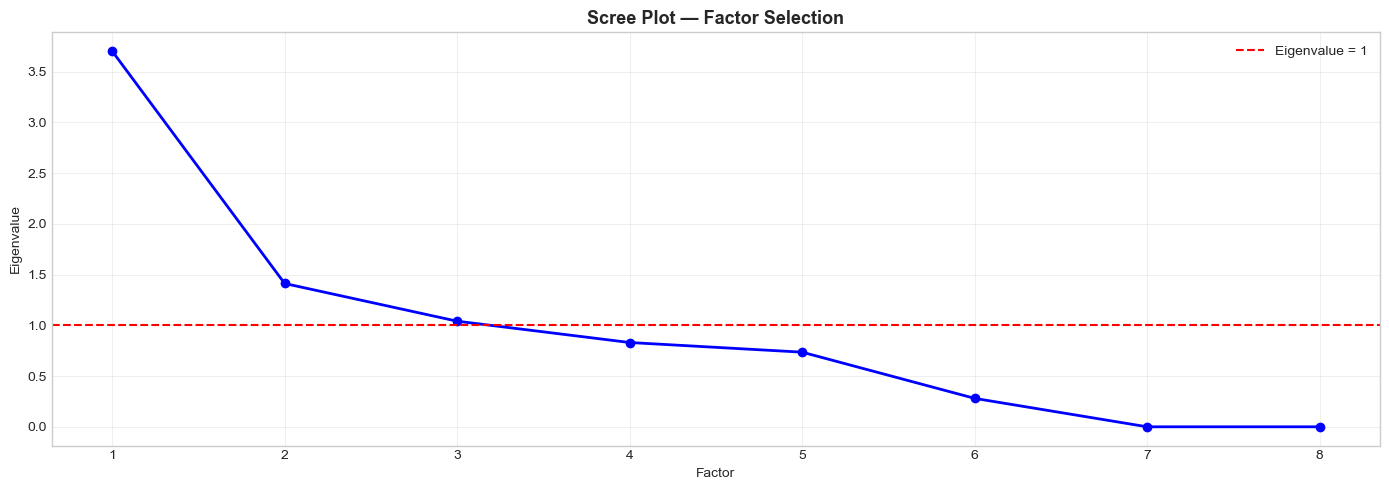


💡 Interpretation:
   • Keep factors with eigenvalue > 1 (red line)
   • Look for the elbow where eigenvalues flatten
   • Typically aim to explain 70–80%+ of variance

STEP 3: Fitting Factor Analysis Model

⚙️  Fitting Factor Analysis and transforming data...

📊 Kaiser criterion suggests 3 factors (λ > 1)
✅ Applied Varimax rotation

✅ Factor Analysis fitted successfully with 3 factors
   Log-likelihood: 17.31
   Mean communality: 62.79%
   Mean uniqueness: 37.21%

✅ Factor Analysis fitted successfully!
   Extracted 3 latent factors

📊 Transformation:
   From 8 features → 3 factors


,Factor,Variance_Explained,Cumulative_Variance,Percentage
Factor1,Factor1,0.4507,0.4507,45.0714
Factor2,Factor2,0.1304,0.5811,13.0353
Factor3,Factor3,0.0468,0.6279,4.6798



📈 Mean communality: 62.8%
📉 Mean uniqueness: 37.2%


,Feature,Communality,Uniqueness,Interpretation
3,TVL_USD,1.0000,0.0000,High Common
2,Volume_USD,1.0000,0.0000,High Common
4,Market_Cap,1.0000,0.0000,High Common
0,Mean_Return,0.7550,0.2450,High Common
1,Volatility,0.6144,0.3856,Moderate
6,ETH_Correlation,0.5247,0.4753,Moderate
5,Liquidity_Score,0.0778,0.9222,Unique
7,Sentiment_Score,0.0510,0.9490,Unique



STEP 4: Analyzing Factor Loadings


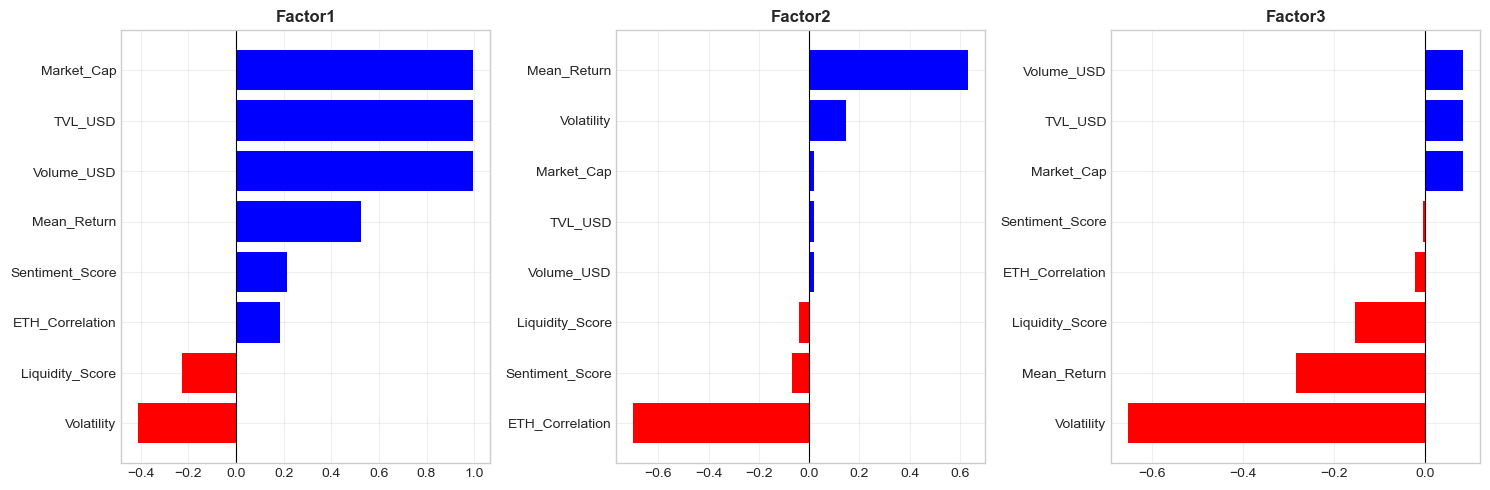

,Factor1,Factor2,Factor3
Mean_Return,0.524,0.633,-0.282
Volatility,-0.411,0.147,-0.651
Volume_USD,0.996,0.018,0.084
TVL_USD,0.996,0.018,0.084
Market_Cap,0.996,0.018,0.084
Liquidity_Score,-0.229,-0.039,-0.154
ETH_Correlation,0.186,-0.700,-0.022
Sentiment_Score,0.216,-0.066,-0.005



💡 Interpretation Tips:
   |Loading| > 0.7 → STRONG relation
   |Loading| 0.4–0.7 → MODERATE relation
   Positive (+) → Feature increases with factor
   Negative (–) → Feature decreases with factor

🏷️  FACTOR INTERPRETATION

Factor1: Variance explained = 45.1%
   Top 3 defining features: Market_Cap, TVL_USD, Volume_USD
   Suggested interpretation: 💰 SIZE / SCALE FACTOR

Factor2: Variance explained = 13.0%
   Top 3 defining features: ETH_Correlation, Mean_Return, Volatility
   Suggested interpretation: 📈 RISK / RETURN FACTOR

Factor3: Variance explained = 4.7%
   Top 3 defining features: Volatility, Mean_Return, Liquidity_Score
   Suggested interpretation: 📈 RISK / RETURN FACTOR

STEP 5: Communality and Uniqueness Visualization


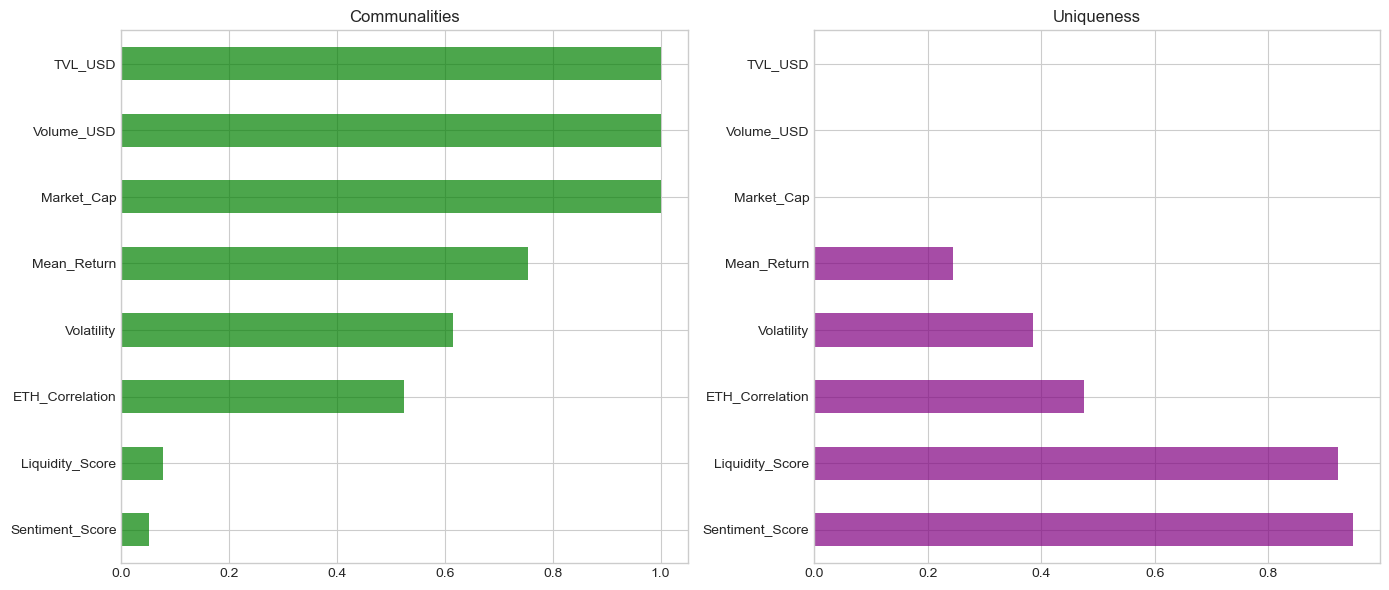


STEP 6: Visualizing Tokens in Factor Space


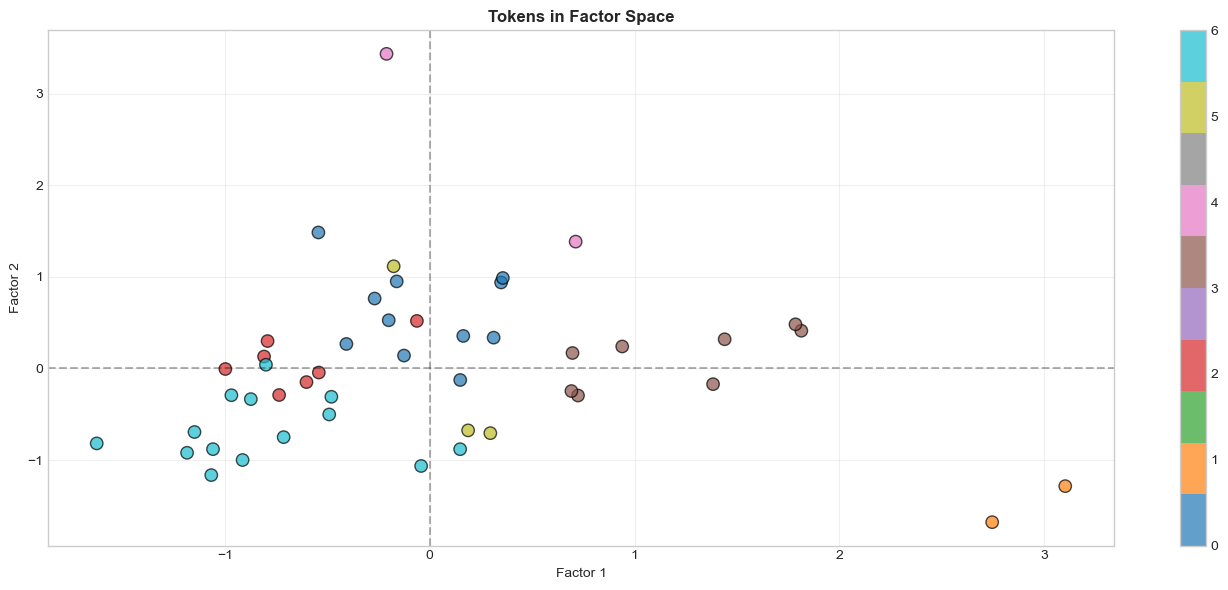


📊 FACTOR ANALYSIS SUMMARY


,Metric,Value
0,Tokens analyzed,47
1,Original features,8
2,Latent factors extracted,3
3,Mean communality,62.8%
4,Mean uniqueness,37.2%
5,Cumulative variance explained,62.8%



✅ Factor Analysis Complete!
   • Revealed underlying dimensions of DeFi data
   • Helps explain risk, liquidity, and scale patterns
   • Supports factor-based portfolio construction


In [24]:
# ==============================================================
#  STEP 2 — FACTOR ANALYSIS ON DEFI FEATURES
# ==============================================================

print("="*70)
print("FITTING FACTOR ANALYSIS TO DeFi PORTFOLIO DATA")
print("="*70)

# STEP 1: Test if data is suitable
print("\n🔬 STEP 1: Testing Factor Analysis Assumptions")
print("-"*70)

fa_model = SimpleFactorAnalysis()
fa_model.test_assumptions(defi_data.values)

# STEP 2: Determine optimal number of factors
print("\n📊 STEP 2: Determining Optimal Number of Factors")
print("-"*70)
print("\n🎯 Creating scree plot to guide factor selection...")

# Scree Plot
fig = fa_model.plot_scree(defi_data.values, figsize=(14, 5))
plt.show()

print("\n💡 Interpretation:")
print("   • Keep factors with eigenvalue > 1 (red line)")
print("   • Look for the elbow where eigenvalues flatten")
print("   • Typically aim to explain 70–80%+ of variance")

# STEP 3: Fit FA model
print("\n" + "="*70)
print("STEP 3: Fitting Factor Analysis Model")
print("="*70)

fa_model = SimpleFactorAnalysis(n_factors=None, rotation='varimax')

print("\n⚙️  Fitting Factor Analysis and transforming data...")
factor_scores = fa_model.fit_transform(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

print("\n✅ Factor Analysis fitted successfully!")
print(f"   Extracted {fa_model.n_factors} latent factors")

# Show dimensions
print(f"\n📊 Transformation:")
print(f"   From {defi_data.shape[1]} features → {factor_scores.shape[1]} factors")

# ==============================================================
#  FACTOR SUMMARY
# ==============================================================

factor_summary = fa_model.get_factor_summary()
display(factor_summary.round(4))

communalities = fa_model.get_communalities()
uniqueness = fa_model.get_uniqueness()

print("\n📈 Mean communality:", f"{communalities.mean():.1%}")
print("📉 Mean uniqueness:", f"{uniqueness.mean():.1%}")

# Communality Summary
comm_summary = pd.DataFrame({
    'Feature': communalities.index,
    'Communality': communalities.values,
    'Uniqueness': uniqueness.values,
    'Interpretation': [
        'High Common' if c > 0.7 else 'Moderate' if c > 0.4 else 'Unique'
        for c in communalities.values
    ]
}).sort_values('Communality', ascending=False)

display(comm_summary.round(4))

# ==============================================================
#  FACTOR LOADINGS
# ==============================================================

print("\n" + "="*70)
print("STEP 4: Analyzing Factor Loadings")
print("="*70)

fig = fa_model.plot_loadings(
    n_factors=min(3, fa_model.n_factors),
    n_top_features=8,
    figsize=(15, 5)
)
plt.show()

loadings = fa_model.get_loadings(rotated=True)
display(loadings.round(3))

print("\n💡 Interpretation Tips:")
print("   |Loading| > 0.7 → STRONG relation")
print("   |Loading| 0.4–0.7 → MODERATE relation")
print("   Positive (+) → Feature increases with factor")
print("   Negative (–) → Feature decreases with factor")

# Factor interpretation
print("\n🏷️  FACTOR INTERPRETATION")
print("="*70)

for i in range(loadings.shape[1]):
    name = f'Factor{i+1}'
    factor_loads = loadings[name].abs().sort_values(ascending=False)
    print(f"\n{name}: Variance explained = {factor_summary['Percentage'].iloc[i]:.1f}%")
    top_features = factor_loads.head(3).index.tolist()

    if any("Volume" in f or "TVL" in f or "Market_Cap" in f for f in top_features):
        meaning = "💰 SIZE / SCALE FACTOR"
    elif any("Return" in f or "Volatility" in f for f in top_features):
        meaning = "📈 RISK / RETURN FACTOR"
    elif any("Liquidity" in f for f in top_features):
        meaning = "💧 LIQUIDITY FACTOR"
    elif any("Sentiment" in f or "ETH" in f for f in top_features):
        meaning = "🌊 MARKET SENTIMENT FACTOR"
    else:
        meaning = "❓ MIXED FACTOR (multiple influences)"
    
    print(f"   Top 3 defining features: {', '.join(top_features)}")
    print(f"   Suggested interpretation: {meaning}")

# ==============================================================
#  COMMUNALITIES VISUALIZATION
# ==============================================================

print("\n" + "="*70)
print("STEP 5: Communality and Uniqueness Visualization")
print("="*70)

fa_model.plot_communalities(figsize=(14, 6))
plt.show()

# ==============================================================
#  FACTOR SCORES VISUALIZATION
# ==============================================================

print("\n" + "="*70)
print("STEP 6: Visualizing Tokens in Factor Space")
print("="*70)

fa_model.plot_factor_scores(factor_scores, labels=defi_data_clustered['Cluster'], figsize=(14, 6))
plt.show()

# ==============================================================
#  SUMMARY
# ==============================================================

print("\n" + "="*70)
print("📊 FACTOR ANALYSIS SUMMARY")
print("="*70)

summary = pd.DataFrame({
    'Metric': [
        'Tokens analyzed',
        'Original features',
        'Latent factors extracted',
        'Mean communality',
        'Mean uniqueness',
        'Cumulative variance explained'
    ],
    'Value': [
        len(defi_data),
        defi_data.shape[1],
        fa_model.n_factors,
        f"{communalities.mean():.1%}",
        f"{uniqueness.mean():.1%}",
        f"{factor_summary['Cumulative_Variance'].iloc[-1]:.1%}"
    ]
})
display(summary)

print("\n✅ Factor Analysis Complete!")
print("   • Revealed underlying dimensions of DeFi data")
print("   • Helps explain risk, liquidity, and scale patterns")
print("   • Supports factor-based portfolio construction")
